# 1.工具包导入

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast

# 2.数据读取

In [6]:
path = 'E:/Machine-learning/kdd_cup_2019/data_set_phase1/'
train_queries = pd.read_csv(path + 'train_queries.csv', parse_dates=['req_time'])
train_plans   = pd.read_csv(path + 'train_plans.csv', parse_dates=['plan_time'])
train_clicks  = pd.read_csv(path + 'train_clicks.csv')
profiles      = pd.read_csv(path + 'profiles.csv') 
test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

#读取节假日信息
holidy_inf    = pd.read_csv('../data/holiday_china_all.csv')


# 3.特征工程

## 3.1  数据集合并

In [7]:
train = train_queries.merge(train_plans, 'left', ['sid'])
test  = test_queries.merge(test_plans, 'left', ['sid'])
train = train.merge(train_clicks, 'left', ['sid'])
train['click_mode'] = train['click_mode'].fillna(0).astype(int)
data  = pd.concat([train, test], ignore_index=True)
data  = data.merge(profiles, 'left', ['pid']) 
print(data)

        click_mode           click_time             d             o       pid  \
0              9.0  2018-11-02 17:54:32  116.32,39.96  116.29,39.97       NaN   
1              1.0  2018-11-16 10:53:32  116.33,39.79  116.39,39.84  210736.0   
2              9.0  2018-10-06 10:34:23  116.27,40.00  116.31,39.93       NaN   
3              1.0  2018-11-23 14:54:18  116.39,39.90  116.27,39.88  202427.0   
4              7.0  2018-10-30 11:49:04  116.37,39.86  116.34,39.96  172251.0   
5              1.0  2018-10-18 07:38:25  116.48,39.76  116.54,39.73  135606.0   
6              1.0  2018-11-20 14:34:48  116.79,40.35  116.34,39.73  189023.0   
7              1.0  2018-10-03 09:19:55  116.24,40.22  116.26,40.22  156954.0   
8              5.0  2018-11-15 15:25:55  116.39,39.90  116.39,39.91  135045.0   
9              3.0  2018-11-08 23:14:06  116.27,39.95  116.29,40.02  176605.0   
10             1.0  2018-10-23 01:02:55  116.37,39.86  116.43,39.95       NaN   
11             1.0  2018-10-

[594358 rows x 75 columns]


（1）这里是将  训练和测试集 合在一起进行处理的， 进行统一的数据预处理和特征工程操作，不过有很大的区分（测试集是没有click_mode的），在构建模型时会进行分离。
（2）可以发现这里是一种完全的合并，将pid这些东西直接合在一起，不管是否为NULL值，lgb是可以直接进行处理，但是当然不自然，这是后续数据处理要思考的点。

## 3.2  经纬度特征
原始经纬度和 坐标间的曼哈顿距离

In [11]:
import math

#哈夫曼距离特征
data['o_lng'] = data['o'].apply(lambda x: float(x.split(',')[0]))
data['o_lat'] = data['o'].apply(lambda x: float(x.split(',')[1]))
data['d_lng'] = data['d'].apply(lambda x: float(x.split(',')[0]))
data['d_lat'] = data['d'].apply(lambda x: float(x.split(',')[1])) 
data['od_manhattan_distance'] = abs(data['o_lng']-data['d_lng'])+abs(data['o_lat']-data['d_lat'])



#另一个距离特征
def GetDistance(lng1, lat1, lng2, lat2):
    EARTH_RADIUS = 6378.137

    lng1 = lng1 * math.pi / 180.0
    lng2 = lng2 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0
    lat2 = lat2 * math.pi / 180.0

    dis1 = lat1 - lat2
    dis2 = lng1 - lng2

    s = 2 * math.asin(
        ((math.sin(dis1 / 2)) ** 2 + math.cos(lat1) * math.cos(lat2) * (math.sin(dis2 / 2)) ** 2) ** 0.5)
    s = s * EARTH_RADIUS * 1000
    return s
data['od_manhattan_distance_detail']=data.apply(lambda row:GetDistance(row['o_lng'],row['o_lat'],row['d_lng'],row['d_lat']),axis=1)



#经纬度与平均值之间的特征
o_co = data[['o']]
d_co = data[['d']]

o_co.columns = ['co']
d_co.columns = ['co']

all_co = pd.concat([d_co, o_co]).drop_duplicates()
all_co['lng'] = all_co['co'].apply(lambda x: float(x.split(',')[0]))
all_co['lat'] = all_co['co'].apply(lambda x: float(x.split(',')[1]))
lng_mean = all_co['lng'].mean()
lat_mean = all_co['lat'].mean()

lng_mode = all_co['lng'].mode()[0]
lat_mode = all_co['lat'].mode()[0]
data['o_main_centroid_mean_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mean_dis'] = abs(
    data['d_lng']-lng_mean)+abs(data['d_lat']-lat_mean)

data['o_main_centroid_mode_dis'] = abs(
    data['o_lng']-lng_mean)+abs(data['o_lat']-lat_mean)
data['d_main_centroid_mode_dis'] = abs(
    data['d_lng']-lng_mode)+abs(data['d_lat']-lat_mode)



#地铁关联特征  （构建与最近的地铁站之间的经纬度距离）
subwayinfo    = pd.read_csv('../data/beijing_subway.csv')
data['o_nearest_dis'] = np.nan
data['d_nearest_dis'] = np.nan

def get_o_near(x):
    return ((abs(subwayinfo['station_longitude']-x['o_lng'])+abs(subwayinfo['station_latitude']-x['o_lat'])).min())
def get_d_near(x):
    print(1)
    return ((abs(subwayinfo['station_longitude']-x['d_lng'])+abs(subwayinfo['station_latitude']-x['d_lat'])).min())

data['o_nearest_dis']=data.apply(get_o_near,axis=1)
data['d_nearest_dis']=data.apply(get_d_near,axis=1) 
# for index in data.index:
#     i=i+1
#     data[index, 'o_nearest_dis'] = (abs(subwayinfo['station_longitude']-data.loc[index]
#                                       ['o_lng'])+abs(subwayinfo['station_latitude']-data.loc[index]['o_lat'])).min()
#     data[index, 'd_nearest_dis'] = (abs(subwayinfo['station_longitude']-data.loc[index]
#                                       ['d_lng'])+abs(subwayinfo['station_latitude']-data.loc[index]['d_lat'])).min()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


这里是对经纬度的原始生成，但是我觉得位置信息可以挖掘出很多的特征，多看看EDA分析下关联关系，进行思考吧，地区编码估计很重要。

## 3.3  plan_time & req_time特征

In [12]:

#原始时间特征上的处理
time_feature = []
for i in ['req_time']:
    data[i + '_hour'] = data[i].dt.hour
    data[i + '_weekday'] = data[i].dt.weekday
    data[i + '_minute'] = data[i].dt.minute
    data[i + '_date_d'] = df['req_time'].dt.strftime('%d').astype(int)
    
    time_feature.append(i + '_hour')
    time_feature.append(i + '_weekday')
    time_feature.append(i + '_minute')   
    time_feature.append(i + '_date_d')      
    
    
    

## 构建时间差特征

In [13]:

#时间差特征上的处理    这里是转化成了秒数差距
data['time_diff'] = (data['plan_time']- data['req_time']).dt.seconds
time_feature.append('time_diff')
#print(data['time_diff'])

## 构建节假日特征
使用one-hot编码

In [14]:
#构建节假日表示特征，分别标识   正常工作日对应结果为 0, 法定节假日对应结果为 1, 节假日调休补班对应的结果为 2，休息日对应结果为 3
# holidy_inf['date'] = holidy_inf['date'].apply(str)
# is_weekday=[]
# is_workday=[]
# is_holiday=[]
# is_tiaoxiu=[]
# for i in data['req_time']:
#     #工作日对应结果为 0, 休息日对应结果为 1, 节假日对应的结果为 2   2018-08-30 19:00:00
#     i=str(i)
#     the_date = datetime.datetime(int(i[0:4]),int(i[5:7]),int(i[8:10]),int(i[11:13]))
# #     print(the_date)
# #     print('周几：',the_date.isoweekday())
# #     print('哪一天：',the_date.day)
#     pan_holiday=holidy_inf[holidy_inf['date']==(str(the_date)[0:4] + str(the_date)[5:7] + str(the_date)[8:10])]  
#     date_flag=pan_holiday['holiday'].values[0]
    
#     print('标识：',date_flag)
#     if date_flag==0:
#         #为工作日
#         is_workday.append(1)
#         is_holiday.append(0)
#         is_tiaoxiu.append(0)
#         is_weekday.append(0)
#     elif date_flag==1:
#         #为节假日
#         is_workday.append(0)
#         is_holiday.append(1)
#         is_tiaoxiu.append(0)
#         is_weekday.append(0)
#     elif date_flag==2:
#         #为调休补班
#         is_workday.append(0)
#         is_holiday.append(0)
#         is_tiaoxiu.append(1)
#         is_weekday.append(0)
#     elif date_flag==3:
#         #为休息日
#         is_workday.append(0)
#         is_holiday.append(0)
#         is_tiaoxiu.append(0)
#         is_weekday.append(1)
# data['is_weekday']=is_weekday
# data['is_workday']=is_workday
# data['is_holiday']=is_holiday
# data['is_tiaoxiu']=is_tiaoxiu

import datetime
#上面的方法效率太低了，放弃，现在使用pandas原生的方法进行生成   真的是简单太多太多了
holidy_inf['date'] = holidy_inf['date'].apply(str)
def get_flag(i):
    i=str(i)
    the_date = datetime.datetime(int(i[0:4]),int(i[5:7]),int(i[8:10]),int(i[11:13]))
    pan_holiday=holidy_inf[holidy_inf['date']==(str(the_date)[0:4] + str(the_date)[5:7] + str(the_date)[8:10])]  
    return pan_holiday['holiday'].values[0]
data['date_flag']=data['req_time'].apply(get_flag)
data=pd.get_dummies(data,columns=['date_flag'],prefix=['holiday_flag'])
print(data.head())

   click_mode           click_time             d             o       pid  \
0         9.0  2018-11-02 17:54:32  116.32,39.96  116.29,39.97       NaN   
1         1.0  2018-11-16 10:53:32  116.33,39.79  116.39,39.84  210736.0   
2         9.0  2018-10-06 10:34:23  116.27,40.00  116.31,39.93       NaN   
3         1.0  2018-11-23 14:54:18  116.39,39.90  116.27,39.88  202427.0   
4         7.0  2018-10-30 11:49:04  116.37,39.86  116.34,39.96  172251.0   

            plan_time                                              plans  \
0 2018-11-02 17:54:30  [{"distance": 5219, "price": 300, "eta": 1367,...   
1 2018-11-16 10:53:10  [{"distance": 13864, "price": 600, "eta": 3221...   
2 2018-10-06 10:33:58  [{"distance": 12294, "price": 400, "eta": 2472...   
3 2018-11-23 14:54:11  [{"distance": 14853, "price": 1700, "eta": 291...   
4 2018-10-30 11:48:41  [{"distance": 12882, "price": 600, "eta": 3211...   

             req_time      sid   p0       ...        d_main_centroid_mode_dis  \
0 201

对时间信息这里挖掘的特别简单，就是时间的小时，星期几，手机规划和进行请求的时间差距。

## 构建下对profile的降维提取特征

In [15]:

print('------  构建针对profile的主成分特征。   ------')
x = profiles.drop(['pid'], axis=1).values
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
svd_x = svd.fit_transform(x)
svd_feas = pd.DataFrame(svd_x)
svd_feas.columns = ['svd_fea_{}'.format(i) for i in range(10)]
svd_feas['pid'] = profiles['pid'].values
data = data.merge(svd_feas, on='pid', how='left')

------  构建针对profile的主成分特征。   ------


## 3.4 plans百度地图推荐特征
   
     此处特征包括：
     *百度地图推荐的距离的统计值(mean,min,max,std)
     *各种交通方式的价格的统计值(mean,min,max,std)
     *各种交通方式的时间的统计值(mean,min,max,std)
     *一些其他的特征,最大距离的交通方式,最高价格的交通方式,最短时间的交通方式等.

In [16]:
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist
    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price
    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta
    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas(data)
plan_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

594358it [01:46, 5568.89it/s]


mode tfidf...


In [17]:

data.to_csv(path + '/feature_data/feature.csv', index=False)
#data=pd.read_csv(path + '/feature_data/feature.csv')

#print(data['holiday_flag_0'])
print(data.head())

   click_mode           click_time             d             o       pid  \
0         9.0  2018-11-02 17:54:32  116.32,39.96  116.29,39.97       NaN   
1         1.0  2018-11-16 10:53:32  116.33,39.79  116.39,39.84  210736.0   
2         9.0  2018-10-06 10:34:23  116.27,40.00  116.31,39.93       NaN   
3         1.0  2018-11-23 14:54:18  116.39,39.90  116.27,39.88  202427.0   
4         7.0  2018-10-30 11:49:04  116.37,39.86  116.34,39.96  172251.0   

            plan_time                                              plans  \
0 2018-11-02 17:54:30  [{"distance": 5219, "price": 300, "eta": 1367,...   
1 2018-11-16 10:53:10  [{"distance": 13864, "price": 600, "eta": 3221...   
2 2018-10-06 10:33:58  [{"distance": 12294, "price": 400, "eta": 2472...   
3 2018-11-23 14:54:11  [{"distance": 14853, "price": 1700, "eta": 291...   
4 2018-10-30 11:48:41  [{"distance": 12882, "price": 600, "eta": 3211...   

             req_time      sid   p0     ...      svd_mode_0  svd_mode_1  \
0 2018-11-0

对plan的使用也是挺简单，和之前自己思考的利用方式有很大的不同，这里主要是对那一系列的推荐生成进行统计来构建特征，而不是使用原始的特征，这样对于每次推荐都可以得到很多不同的统计特征。   这里发现这里实在有很多 缺值情况下直接训练的，让模型自己填充，这是一个工作量空间

还是使用pycharm下管理比较舒服，这里数据观察都不太方便。

# 4.训练和测试部分

## 4.1 设计评估指标

In [18]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [26]:
print(plan_features)
print(time_feature)

print(data.columns)

['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
['time_diff']
Index(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0',
       ...
       'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4',
       'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9'],
      dtype='object', length=156)


## 4.2 模型验证
   此处文章说，可以达到线上和线下的已知，这里在线下使用7天作为验证集进行使用(这里是看过EDA进行的选择， 使用中间的7天作为结果的验证)

In [44]:
#这里是自己组建需要使用的特征
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
holiday_featur     = ['holiday_flag_0','holiday_flag_1','holiday_flag_3']
subway_feature     = ['od_manhattan_distance','o_nearest_dis','d_nearest_dis']

prof_svd = ['svd_fea_{}'.format(i) for i in range(20)]
other_feature      = ['od_manhattan_distance_detail','o_main_centroid_mean_dis','d_main_centroid_mean_dis','o_main_centroid_mode_dis','d_main_centroid_mode_dis']



feature            = origin_num_feature + cate_feature + plan_features + time_feature  +holiday_featur+subway_feature+other_feature

train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=100, reg_alpha=0, reg_lambda=20,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.02, random_state=2019, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=200)


124 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=100,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=20, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

实验记录：
 
     （1）杰少baseline
         线下：0.68712632249049           线上：0.68971719
     （2）杰少baseline +节假日特征one-hot编码 + 地铁信息 + 始终点哈夫曼距离  
         线下：0.687215                   线上：
     （3）在2上基础上设置 学习率为0.01 : 
         线下：0.687412 (速度太慢了)      线上：0.68955010                       线上有下降
     （4）在2基础上去除一些低重要度的特征（去除了13个重要度较低的p特征， 看来冗余度很小，没必要去除特征）
         线下： 0.687047                  线上：0.68834645                       线上有下降
     （5）在2基础上加上 夕给的距离式子  +  对profile的svd表示  +  起终点距离 平均位置的结果 (这里看样子冗余挺大，导致降分。)
         线下： 0.686965                  
     （6）在5基础上去掉fill时候设置的category_feat （）
         线下： 0.687739                  线上：0.69029841
     （7）在2的基础上去除fill时候设置的category_feat
         线下： 0.68847
     （7）在2的基础上去除fill时候设置的category_feat   同时去除节假日特征one-hot编码 + 地铁信息   
         线下： 0.68847 
     （8）origin_num_feature + cate_feature + plan_features + time_feature  +holiday_featur+subway_feature  设置num_leaves=100, reg_lambda=20 200次early_sto,plearning_rate=0.02
      
         线下： 0.689314                  线上：0.6913
     （9）origin_num_feature + cate_feature + plan_features + time_feature  +holiday_featur+subway_feature+other_feature   设置同8
         线下：0.689398

#模型构建方式一  杰少
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)


#模型构建方式二   （队友提供的）
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=120, reg_alpha=0, reg_lambda=20,
        max_depth=-1, n_estimators=2000, objective='multiclass',
        subsample=0.8, colsample_bytree=0.8, subsample_freq=1, min_child_samples = 50,  learning_rate=0.03, random_state=2019, metric="multi_logloss",n_jobs=-1)
eval_set = [(train_x, train_y),(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, 
              verbose=50, early_stopping_rounds=200)

## 4.3 特征重要度分析

Text(0.5,1,'the lgb model')

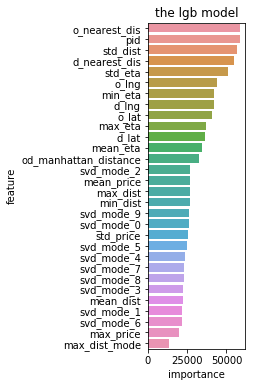

In [41]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp.to_csv(path + '/feature_data/feature_import.csv')


#绘制特征重要度图
plt.figure(figsize=(8,6))
plt.subplot(142)
col_imp=pd.DataFrame({'feature':imp['fea'],'importance':imp['imp']}).sort_values(by='importance',ascending=False)
sns.barplot(x=col_imp['importance'][0:30],y=col_imp['feature'][0:30],orient='h')
plt.title('the lgb model')

## 4.4 预测结果分析

In [42]:
pred = lgb_model.predict(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.08741402158137186 0.3566048667439166 0.9031548055759354 0.22216206460927632
1 0.1446172777181801 0.6845520581113801 0.6155185927022555 0.7710265081269772
2 0.313324288508866 0.9014510563879566 0.8494187859083419 0.9602739036302301
3 0.04459834669022528 0.09866583928017375 0.4015151515151515 0.05624336752741422
4 0.024452577774973182 0.01644528779253637 0.41935483870967744 0.008387096774193548
5 0.0975736732504575 0.8415300546448088 0.774500475737393 0.9212611156022635
6 0.01989335520918786 0.1638755980861244 0.3333333333333333 0.10864393338620143
7 0.17792011106203068 0.7893751462672596 0.7046657381615599 0.8972335520482355
8 0.004559222565785322 0.26501035196687367 0.32989690721649484 0.22145328719723184
9 0.04993058623083233 0.5167597765363128 0.5774483027701912 0.4676145339652449
10 0.028475421215371995 0.5556891989415443 0.49107142857142855 0.6398891966759003
11 0.007241118192717865 0.44796380090497745 0.46588235294117647 0.43137254901960786
0.6893138248234267


## 4.5预测和线上提交

In [43]:
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)   #best_iteration_  选择最好的一次迭代次数再次进行训练
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv(path + '/sub/baseline.csv', index=False)

985
fit over
94358
2     34148
7     22439
1     17950
5     10878
10     3397
0      2131
9      1833
3       508
11      406
6       365
8       242
4        61
Name: recommend_mode, dtype: int64


# 额外尝试

In [84]:
print(1)

1


In [97]:
weather_for=pd.read_csv('C:/Users/Administrator/Desktop/cache.csv',index_col=0)
weather_for

apparentTemperature  cloudCover             datetime  dewPoint  humidity  \
0                 13.87         NaN  2018-10-01 00:00:00      5.00      0.55   
1                 16.87         NaN  2018-10-01 01:00:00      4.01      0.42   
2                 16.87         NaN  2018-10-01 02:00:00      4.01      0.42   
3                 15.87         NaN  2018-10-01 03:00:00      4.01      0.45   
4                 15.87         NaN  2018-10-01 04:00:00      4.01      0.45   
5                 15.87         NaN  2018-10-01 05:00:00      4.01      0.45   
6                 15.87         NaN  2018-10-01 06:00:00      4.01      0.45   
7                 16.87         NaN  2018-10-01 07:00:00      4.01      0.42   
8                 18.87         NaN  2018-10-01 08:00:00      4.01      0.37   
9                 20.88         NaN  2018-10-01 09:00:00      4.01      0.33   
10                22.86         NaN  2018-10-01 10:00:00      4.01      0.29   
11                23.87         NaN  2018-10-01 11:00:00      1.99      0.24   
12                25.88         NaN  2018-10-01 12:00:00      0.98      0.20   
13                25.88         NaN  2018-10-01 13:00:00      0.01      0.18   
14                26.86         NaN  2018-10-01 14:00:00      0.01      0.17   
15                26.86         NaN  2018-10-01 15:00:00      0.98      0.19   
16                26.86         NaN  2018-10-01 16:00:00      0.01      0.17   
17                25.88         NaN  2018-10-01 17:00:00      0.01      0.18   
18                23.87         NaN  2018-10-01 18:00:00      0.01      0.21   
19                22.86         NaN  2018-10-01 19:00:00      0.01      0.22   
20                21.88         NaN  2018-10-01 20:00:00      0.99      0.25   
21                20.88         NaN  2018-10-01 21:00:00      0.99      0.27   
22                14.87         NaN  2018-10-01 22:00:00      3.00      0.45   
23                18.87         NaN  2018-10-01 23:00:00      2.00      0.32   
24                17.87         NaN  2018-10-02 00:00:00      2.00      0.35   
25                17.87         NaN  2018-10-02 01:00:00      2.00      0.35   
26                13.87         NaN  2018-10-02 02:00:00      3.00      0.48   
27                11.87         NaN  2018-10-02 03:00:00      6.00      0.67   
28                11.87         NaN  2018-10-02 04:00:00      5.00      0.63   
29                10.87         NaN  2018-10-02 05:00:00      6.00      0.72   
..                  ...         ...                  ...       ...       ...   
18               -13.78         NaN  2018-12-28 18:00:00    -27.90      0.16   
19               -13.78         NaN  2018-12-28 19:00:00    -26.89      0.17   
20               -12.57         NaN  2018-12-28 20:00:00    -26.89      0.17   
21               -12.57         NaN  2018-12-28 21:00:00    -26.89      0.17   
22               -13.22         NaN  2018-12-28 22:00:00    -27.90      0.16   
23               -12.57         NaN  2018-12-28 23:00:00    -27.90      0.16   
0                -11.81         NaN  2018-12-29 00:00:00    -26.89      0.17   
1                 -9.59         NaN  2018-12-29 01:00:00    -27.90      0.16   
2                -12.57         NaN  2018-12-29 02:00:00    -27.90      0.16   
3                -13.04         NaN  2018-12-29 03:00:00    -27.90      0.17   
4                -13.04         NaN  2018-12-29 04:00:00    -28.86      0.16   
5                -14.49         NaN  2018-12-29 05:00:00    -28.86      0.16   
6                -15.07         NaN  2018-12-29 06:00:00    -28.87      0.17   
7                -15.48         NaN  2018-12-29 07:00:00    -28.87      0.18   
8                -15.07         NaN  2018-12-29 08:00:00    -27.91      0.19   
9                -10.57         NaN  2018-12-29 09:00:00    -27.90      0.15   
10               -11.19         NaN  2018-12-29 10:00:00    -28.86      0.12   
11               -10.37         NaN  2018-12-29 11:00:00    -27.89      0.13   
12  

In [98]:
weather_for=weather_for[weather_for['station_id']!='dongsi_aq']

In [99]:
weather_for.drop_duplicates(subset=None, keep='first', inplace=True)


In [100]:
weather_for.to_csv('C:/Users/Administrator/Desktop/weather_for.csv')

In [102]:
print(time_feature)

['time_diff']


In [ ]:
print(data['od_label_encoder'])
print(data['o_labe_encoder'])
print(data['d_labe_encoder'])



In [12]:
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))

plans = np.dstack((np.repeat(data['sid'].values,list(map(len,data['plans_json'].values))),np.concatenate(data['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)



{'distance': 4537, 'price': '', 'eta': 1035, 'transport_mode': 3}


In [18]:
print(plans.iloc[0])

sid                                                         3000821
plans             {'distance': 5219, 'price': 300, 'eta': 1367, ...
distance                                                       5219
eta                                                            1367
price                                                           300
transport_mode                                                    9
Name: 0, dtype: object


In [19]:
print(plans.count())

sid               2706625
plans             2706625
distance          2706625
eta               2706625
price             2706625
transport_mode    2706625
dtype: int64


#### 这里尝试 对于转化率特征的提取
先构建plan的列平展，之后再进行非本行的统计

In [3]:
path = 'E:/Machine-learning/kdd_cup_2019/data_set_phase1/'
data=pd.read_csv(path + '/feature_data/feature.csv',parse_dates=['req_time','plan_time'])

#这里测试下，进行转化率特征的提取
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
train_index = (data.req_time < '2018-12-01')
train     = data[train_index].reset_index(drop=True)

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)



In [5]:
print(plans)


             sid     pid click_mode  \
0        3000821     NaN          9   
1        3000821     NaN          9   
2        3000821     NaN          9   
3        3000821     NaN          9   
4        3000821     NaN          9   
5        3000821     NaN          9   
6        3085857  210736          1   
7        3085857  210736          1   
8        3085857  210736          1   
9        3085857  210736          1   
10       3085857  210736          1   
11       2944522     NaN          9   
12       2944522     NaN          9   
13       2944522     NaN          9   
14       2944522     NaN          9   
15       2944522     NaN          9   
16       2944522     NaN          9   
17       2944522     NaN          9   
18        559931  202427          1   
19        559931  202427          1   
20        559931  202427          1   
21        559931  202427          1   
22        559931  202427          1   
23       2819352  172251          7   
24       2819352  172251 

[2276822 rows x 8 columns]


利用上面的信息进行每一行上的非本行的信息的统计

In [10]:
#这里测试下，进行转化率特征的提取
# data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
# train_index = (data.req_time < '2018-12-01')
# train     = data[train_index].reset_index(drop=True)

# plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
# plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
# plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)



#对每一个sid，去计算 其他sid行上这个pid的点击情况 和转化率情况
#对于每一行单独进行     除此行之外的转化率情况的提取。
#data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
plans_all_data=plans
plans=plans_all_data[['sid','pid','click_mode','transport_mode']]

data_a=data[['sid','pid']]
def  get_CVR_feature(data_a):
    
    
    features=[]
    for i, row in tqdm(data_a.iterrows()):
        
        the_other_data_row=plans[plans['sid']!=row['sid']]
        feature={}        
        use_get_CVR_plans_rows=the_other_data_row[the_other_data_row['pid']==row['pid']]  
        
        pid_mode_0_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==0)])
        pid_mode_1_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==1)])
        pid_mode_2_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==2)])    
        pid_mode_3_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==3)]) 
        pid_mode_4_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==4)]) 
        pid_mode_5_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==5)]) 
        pid_mode_6_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==6)]) 
        pid_mode_7_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==7)]) 
        pid_mode_8_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==8)]) 
        pid_mode_9_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==9)]) 
        pid_mode_10_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==10)]) 
        pid_mode_11_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['transport_mode']==11)]) 
        
        
        feature['pid_mode_0_appear_count']=pid_mode_0_count
        feature['pid_mode_1_appear_count']=pid_mode_1_count
        feature['pid_mode_2_appear_count']=pid_mode_2_count
        feature['pid_mode_3_appear_count']=pid_mode_3_count
        feature['pid_mode_4_appear_count']=pid_mode_4_count
        feature['pid_mode_5_appear_count']=pid_mode_5_count
        feature['pid_mode_6_appear_count']=pid_mode_6_count
        feature['pid_mode_7_appear_count']=pid_mode_7_count
        feature['pid_mode_8_appear_count']=pid_mode_8_count
        feature['pid_mode_9_appear_count']=pid_mode_9_count
        feature['pid_mode_10_appear_count']=pid_mode_10_count
        feature['pid_mode_11_appear_count']=pid_mode_11_count
        
        features.append(feature)
    features=pd.DataFrame(features)
    return features

get_mode_appear_count_data=get_CVR_feature(data_a)
            
            



0it [00:00, ?it/s]

1it [00:00,  1.35it/s]

2it [00:01,  1.22it/s]

3it [00:02,  1.22it/s]

4it [00:03,  1.17it/s]

5it [00:04,  1.14it/s]

6it [00:05,  1.11it/s]

7it [00:06,  1.11it/s]

8it [00:07,  1.08it/s]

9it [00:08,  1.08it/s]

10it [00:09,  1.07it/s]

11it [00:09,  1.11it/s]

12it [00:10,  1.09it/s]

13it [00:11,  1.15it/s]

14it [00:12,  1.11it/s]

15it [00:13,  1.16it/s]

16it [00:14,  1.18it/s]

17it [00:15,  1.14it/s]

18it [00:16,  1.12it/s]

19it [00:17,  1.09it/s]

20it [00:18,  1.08it/s]

21it [00:18,  1.14it/s]

22it [00:19,  1.11it/s]

23it [00:20,  1.07it/s]

24it [00:21,  1.06it/s]

25it [00:22,  1.05it/s]

26it [00:23,  1.03it/s]

27it [00:24,  1.05it/s]

28it [00:25,  1.05it/s]

29it [00:26,  1.04it/s]

30it [00:27,  1.11it/s]

31it [00:28,  1.13it/s]

32it [00:28,  1.16it/s]

33it [00:29,  1.11it/s]

34it [00:30,  1.13it/s]

35it [00:31,  1.11it/s]

36it [00:32,  1.15it/s]

37it [00:33,  1.17it/s]

38it [00:34,  1.15it/s]

39it [00:35,  1.16it/s]

40it [00:36,

634it [09:34,  1.11it/s]

635it [09:34,  1.15it/s]

636it [09:35,  1.11it/s]

637it [09:36,  1.08it/s]

638it [09:37,  1.13it/s]

639it [09:38,  1.16it/s]

640it [09:39,  1.18it/s]

641it [09:39,  1.22it/s]

642it [09:40,  1.16it/s]

643it [09:41,  1.13it/s]

644it [09:42,  1.16it/s]

645it [09:43,  1.12it/s]

646it [09:44,  1.16it/s]

647it [09:45,  1.11it/s]

648it [09:46,  1.08it/s]

649it [09:47,  1.12it/s]

650it [09:48,  1.11it/s]

651it [09:48,  1.17it/s]

652it [09:49,  1.12it/s]

653it [09:50,  1.16it/s]

654it [09:51,  1.11it/s]

655it [09:52,  1.10it/s]

656it [09:53,  1.07it/s]

657it [09:54,  1.11it/s]

658it [09:55,  1.10it/s]

659it [09:56,  1.14it/s]

660it [09:57,  1.11it/s]

661it [09:58,  1.08it/s]

662it [09:58,  1.07it/s]

663it [09:59,  1.12it/s]

664it [10:00,  1.08it/s]

665it [10:01,  1.13it/s]

666it [10:02,  1.11it/s]

667it [10:03,  1.14it/s]

668it [10:04,  1.19it/s]

669it [10:05,  1.13it/s]

670it [10:06,  1.11it/s]

671it [10:06,  1.14it/s]

672it [10:07

1254it [18:57,  1.16it/s]

1255it [18:58,  1.11it/s]

1256it [18:59,  1.09it/s]

1257it [19:00,  1.07it/s]

1258it [19:00,  1.12it/s]

1259it [19:01,  1.10it/s]

1260it [19:02,  1.08it/s]

1261it [19:03,  1.14it/s]

1262it [19:04,  1.16it/s]

1263it [19:05,  1.18it/s]

1264it [19:06,  1.13it/s]

1265it [19:07,  1.10it/s]

1266it [19:08,  1.08it/s]

1267it [19:09,  1.06it/s]

1268it [19:10,  1.05it/s]

1269it [19:10,  1.11it/s]

1270it [19:11,  1.10it/s]

1271it [19:12,  1.08it/s]

1272it [19:13,  1.08it/s]

1273it [19:14,  1.07it/s]

1274it [19:15,  1.12it/s]

1275it [19:16,  1.09it/s]

1276it [19:17,  1.09it/s]

1277it [19:18,  1.09it/s]

1278it [19:19,  1.08it/s]

1279it [19:20,  1.06it/s]

1280it [19:21,  1.09it/s]

1281it [19:22,  1.06it/s]

1282it [19:22,  1.07it/s]

1283it [19:23,  1.13it/s]

1284it [19:24,  1.11it/s]

1285it [19:25,  1.08it/s]

1286it [19:26,  1.07it/s]

1287it [19:27,  1.11it/s]

1288it [19:28,  1.16it/s]

1289it [19:29,  1.20it/s]

1290it [19:29,  1.21it/s]

1

1860it [28:12,  1.02it/s]

1861it [28:13,  1.02it/s]

1862it [28:13,  1.03it/s]

1863it [28:14,  1.08it/s]

1864it [28:15,  1.06it/s]

1865it [28:16,  1.06it/s]

1866it [28:17,  1.04it/s]

1867it [28:18,  1.03it/s]

1868it [28:19,  1.04it/s]

1869it [28:20,  1.03it/s]

1870it [28:21,  1.02it/s]

1871it [28:22,  1.02it/s]

1872it [28:23,  1.00it/s]

1873it [28:24,  1.01it/s]

1874it [28:25,  1.02it/s]

1875it [28:26,  1.02it/s]

1876it [28:27,  1.03it/s]

1877it [28:28,  1.03it/s]

1878it [28:29,  1.03it/s]

1879it [28:30,  1.09it/s]

1880it [28:31,  1.13it/s]

1881it [28:32,  1.09it/s]

1882it [28:33,  1.07it/s]

1883it [28:34,  1.06it/s]

1884it [28:34,  1.05it/s]

1885it [28:35,  1.04it/s]

1886it [28:36,  1.09it/s]

1887it [28:37,  1.06it/s]

1888it [28:38,  1.04it/s]

1889it [28:39,  1.02it/s]

1890it [28:40,  1.07it/s]

1891it [28:41,  1.05it/s]

1892it [28:42,  1.04it/s]

1893it [28:43,  1.10it/s]

1894it [28:44,  1.08it/s]

1895it [28:45,  1.06it/s]

1896it [28:46,  1.09it/s]

1

2466it [37:32,  1.15it/s]

2467it [37:33,  1.17it/s]

2468it [37:34,  1.11it/s]

2469it [37:35,  1.08it/s]

2470it [37:36,  1.12it/s]

2471it [37:37,  1.14it/s]

2472it [37:38,  1.17it/s]

2473it [37:39,  1.12it/s]

2474it [37:40,  1.08it/s]

2475it [37:40,  1.07it/s]

2476it [37:41,  1.12it/s]

2477it [37:42,  1.10it/s]

2478it [37:43,  1.08it/s]

2479it [37:44,  1.06it/s]

2480it [37:45,  1.04it/s]

2481it [37:46,  1.09it/s]

2482it [37:47,  1.06it/s]

2483it [37:48,  1.05it/s]

2484it [37:49,  1.04it/s]

2485it [37:50,  1.08it/s]

2486it [37:51,  1.10it/s]

2487it [37:51,  1.15it/s]

2488it [37:52,  1.11it/s]

2489it [37:53,  1.13it/s]

2490it [37:54,  1.10it/s]

2491it [37:55,  1.14it/s]

2492it [37:56,  1.17it/s]

2493it [37:57,  1.13it/s]

2494it [37:58,  1.09it/s]

2495it [37:59,  1.14it/s]

2496it [38:00,  1.11it/s]

2497it [38:01,  1.07it/s]

2498it [38:02,  1.06it/s]

2499it [38:02,  1.04it/s]

2500it [38:03,  1.04it/s]

2501it [38:04,  1.09it/s]

2502it [38:05,  1.06it/s]

2

3072it [46:55,  1.09it/s]

3073it [46:56,  1.09it/s]

3074it [46:57,  1.05it/s]

3075it [46:58,  1.04it/s]

3076it [46:59,  1.03it/s]

3077it [47:00,  1.02it/s]

3078it [47:01,  1.02it/s]

3079it [47:02,  1.02it/s]

3080it [47:03,  1.08it/s]

3081it [47:04,  1.06it/s]

3082it [47:05,  1.04it/s]

3083it [47:05,  1.09it/s]

3084it [47:06,  1.08it/s]

3085it [47:07,  1.06it/s]

3086it [47:08,  1.04it/s]

3087it [47:09,  1.05it/s]

3088it [47:10,  1.05it/s]

3089it [47:11,  1.05it/s]

3090it [47:12,  1.03it/s]

3091it [47:13,  1.02it/s]

3092it [47:14,  1.02it/s]

3093it [47:15,  1.02it/s]

3094it [47:16,  1.03it/s]

3095it [47:17,  1.07it/s]

3096it [47:18,  1.06it/s]

3097it [47:19,  1.05it/s]

3098it [47:20,  1.09it/s]

3099it [47:21,  1.14it/s]

3100it [47:21,  1.12it/s]

3101it [47:22,  1.09it/s]

3102it [47:23,  1.08it/s]

3103it [47:24,  1.07it/s]

3104it [47:25,  1.06it/s]

3105it [47:26,  1.07it/s]

3106it [47:27,  1.11it/s]

3107it [47:28,  1.10it/s]

3108it [47:29,  1.07it/s]

3

3678it [56:03,  1.05it/s]

3679it [56:04,  1.05it/s]

3680it [56:05,  1.04it/s]

3681it [56:06,  1.05it/s]

3682it [56:07,  1.11it/s]

3683it [56:07,  1.10it/s]

3684it [56:08,  1.09it/s]

3685it [56:09,  1.13it/s]

3686it [56:10,  1.17it/s]

3687it [56:11,  1.21it/s]

3688it [56:12,  1.23it/s]

3689it [56:12,  1.17it/s]

3690it [56:13,  1.15it/s]

3691it [56:14,  1.12it/s]

3692it [56:15,  1.10it/s]

3693it [56:16,  1.13it/s]

3694it [56:17,  1.11it/s]

3695it [56:18,  1.15it/s]

3696it [56:19,  1.13it/s]

3697it [56:20,  1.10it/s]

3698it [56:21,  1.15it/s]

3699it [56:21,  1.12it/s]

3700it [56:22,  1.16it/s]

3701it [56:23,  1.13it/s]

3702it [56:24,  1.11it/s]

3703it [56:25,  1.08it/s]

3704it [56:26,  1.08it/s]

3705it [56:27,  1.06it/s]

3706it [56:28,  1.07it/s]

3707it [56:29,  1.07it/s]

3708it [56:30,  1.13it/s]

3709it [56:31,  1.12it/s]

3710it [56:31,  1.10it/s]

3711it [56:32,  1.08it/s]

3712it [56:33,  1.08it/s]

3713it [56:34,  1.07it/s]

3714it [56:35,  1.07it/s]

3

4260it [1:04:44,  1.10it/s]

4261it [1:04:45,  1.08it/s]

4262it [1:04:46,  1.13it/s]

4263it [1:04:47,  1.10it/s]

4264it [1:04:48,  1.06it/s]

4265it [1:04:49,  1.07it/s]

4266it [1:04:50,  1.13it/s]

4267it [1:04:51,  1.16it/s]

4268it [1:04:51,  1.18it/s]

4269it [1:04:52,  1.15it/s]

4270it [1:04:53,  1.13it/s]

4271it [1:04:54,  1.10it/s]

4272it [1:04:55,  1.08it/s]

4273it [1:04:56,  1.14it/s]

4274it [1:04:57,  1.18it/s]

4275it [1:04:58,  1.15it/s]

4276it [1:04:59,  1.10it/s]

4277it [1:05:00,  1.08it/s]

4278it [1:05:00,  1.12it/s]

4279it [1:05:01,  1.17it/s]

4280it [1:05:02,  1.20it/s]

4281it [1:05:03,  1.16it/s]

4282it [1:05:04,  1.12it/s]

4283it [1:05:05,  1.10it/s]

4284it [1:05:06,  1.14it/s]

4285it [1:05:06,  1.17it/s]

4286it [1:05:07,  1.19it/s]

4287it [1:05:08,  1.20it/s]

4288it [1:05:09,  1.22it/s]

4289it [1:05:10,  1.17it/s]

4290it [1:05:11,  1.15it/s]

4291it [1:05:12,  1.13it/s]

4292it [1:05:13,  1.11it/s]

4293it [1:05:13,  1.13it/s]

4294it [1:05:1

4824it [1:13:09,  1.12it/s]

4825it [1:13:10,  1.09it/s]

4826it [1:13:11,  1.08it/s]

4827it [1:13:12,  1.08it/s]

4828it [1:13:13,  1.08it/s]

4829it [1:13:14,  1.08it/s]

4830it [1:13:15,  1.08it/s]

4831it [1:13:16,  1.06it/s]

4832it [1:13:17,  1.11it/s]

4833it [1:13:18,  1.09it/s]

4834it [1:13:19,  1.08it/s]

4835it [1:13:19,  1.12it/s]

4836it [1:13:20,  1.10it/s]

4837it [1:13:21,  1.09it/s]

4838it [1:13:22,  1.14it/s]

4839it [1:13:23,  1.16it/s]

4840it [1:13:24,  1.11it/s]

4841it [1:13:25,  1.10it/s]

4842it [1:13:26,  1.08it/s]

4843it [1:13:27,  1.09it/s]

4844it [1:13:28,  1.06it/s]

4845it [1:13:29,  1.11it/s]

4846it [1:13:29,  1.15it/s]

4847it [1:13:30,  1.13it/s]

4848it [1:13:31,  1.10it/s]

4849it [1:13:32,  1.08it/s]

4850it [1:13:33,  1.08it/s]

4851it [1:13:34,  1.07it/s]

4852it [1:13:35,  1.06it/s]

4853it [1:13:36,  1.07it/s]

4854it [1:13:37,  1.07it/s]

4855it [1:13:38,  1.12it/s]

4856it [1:13:38,  1.17it/s]

4857it [1:13:39,  1.13it/s]

4858it [1:13:4

5388it [1:21:31,  1.14it/s]

5389it [1:21:32,  1.11it/s]

5390it [1:21:33,  1.09it/s]

5391it [1:21:34,  1.09it/s]

5392it [1:21:35,  1.08it/s]

5393it [1:21:35,  1.14it/s]

5394it [1:21:36,  1.19it/s]

5395it [1:21:37,  1.20it/s]

5396it [1:21:38,  1.17it/s]

5397it [1:21:39,  1.20it/s]

5398it [1:21:40,  1.15it/s]

5399it [1:21:41,  1.11it/s]

5400it [1:21:41,  1.15it/s]

5401it [1:21:42,  1.12it/s]

5402it [1:21:43,  1.10it/s]

5403it [1:21:44,  1.15it/s]

5404it [1:21:45,  1.13it/s]

5405it [1:21:46,  1.11it/s]

5406it [1:21:47,  1.09it/s]

5407it [1:21:48,  1.13it/s]

5408it [1:21:48,  1.16it/s]

5409it [1:21:49,  1.18it/s]

5410it [1:21:50,  1.21it/s]

5411it [1:21:51,  1.17it/s]

5412it [1:21:52,  1.14it/s]

5413it [1:21:53,  1.12it/s]

5414it [1:21:54,  1.16it/s]

5415it [1:21:55,  1.13it/s]

5416it [1:21:55,  1.18it/s]

5417it [1:21:56,  1.15it/s]

5418it [1:21:57,  1.19it/s]

5419it [1:21:58,  1.14it/s]

5420it [1:21:59,  1.11it/s]

5421it [1:22:00,  1.09it/s]

5422it [1:22:0

5952it [1:29:56,  1.08it/s]

5953it [1:29:57,  1.07it/s]

5954it [1:29:58,  1.06it/s]

5955it [1:29:59,  1.05it/s]

5956it [1:29:59,  1.13it/s]

5957it [1:30:00,  1.11it/s]

5958it [1:30:01,  1.08it/s]

5959it [1:30:02,  1.12it/s]

5960it [1:30:03,  1.11it/s]

5961it [1:30:04,  1.08it/s]

5962it [1:30:05,  1.07it/s]

5963it [1:30:06,  1.07it/s]

5964it [1:30:07,  1.06it/s]

5965it [1:30:08,  1.05it/s]

5966it [1:30:09,  1.07it/s]

5967it [1:30:10,  1.11it/s]

5968it [1:30:11,  1.09it/s]

5969it [1:30:12,  1.06it/s]

5970it [1:30:13,  1.05it/s]

5971it [1:30:13,  1.10it/s]

5972it [1:30:14,  1.14it/s]

5973it [1:30:15,  1.18it/s]

5974it [1:30:16,  1.13it/s]

5975it [1:30:17,  1.11it/s]

5976it [1:30:18,  1.08it/s]

5977it [1:30:19,  1.06it/s]

5978it [1:30:20,  1.06it/s]

5979it [1:30:21,  1.06it/s]

5980it [1:30:22,  1.05it/s]

5981it [1:30:23,  1.11it/s]

5982it [1:30:23,  1.14it/s]

5983it [1:30:24,  1.12it/s]

5984it [1:30:25,  1.11it/s]

5985it [1:30:26,  1.15it/s]

5986it [1:30:2

6516it [1:38:22,  1.09it/s]

6517it [1:38:23,  1.07it/s]

6518it [1:38:23,  1.13it/s]

6519it [1:38:24,  1.11it/s]

6520it [1:38:25,  1.10it/s]

6521it [1:38:26,  1.09it/s]

6522it [1:38:27,  1.08it/s]

6523it [1:38:28,  1.14it/s]

6524it [1:38:29,  1.11it/s]

6525it [1:38:30,  1.10it/s]

6526it [1:38:31,  1.08it/s]

6527it [1:38:32,  1.07it/s]

6528it [1:38:33,  1.07it/s]

6529it [1:38:34,  1.06it/s]

6530it [1:38:35,  1.06it/s]

6531it [1:38:35,  1.06it/s]

6532it [1:38:36,  1.06it/s]

6533it [1:38:37,  1.12it/s]

6534it [1:38:38,  1.10it/s]

6535it [1:38:39,  1.07it/s]

6536it [1:38:40,  1.12it/s]

6537it [1:38:41,  1.10it/s]

6538it [1:38:42,  1.08it/s]

6539it [1:38:43,  1.07it/s]

6540it [1:38:44,  1.12it/s]

6541it [1:38:45,  1.09it/s]

6542it [1:38:45,  1.15it/s]

6543it [1:38:46,  1.12it/s]

6544it [1:38:47,  1.10it/s]

6545it [1:38:48,  1.07it/s]

6546it [1:38:49,  1.06it/s]

6547it [1:38:50,  1.11it/s]

6548it [1:38:51,  1.08it/s]

6549it [1:38:52,  1.07it/s]

6550it [1:38:5

7080it [1:46:47,  1.07it/s]

7081it [1:46:48,  1.07it/s]

7082it [1:46:49,  1.06it/s]

7083it [1:46:50,  1.13it/s]

7084it [1:46:50,  1.16it/s]

7085it [1:46:51,  1.13it/s]

7086it [1:46:52,  1.18it/s]

7087it [1:46:53,  1.14it/s]

7088it [1:46:54,  1.12it/s]

7089it [1:46:55,  1.10it/s]

7090it [1:46:56,  1.14it/s]

7091it [1:46:57,  1.19it/s]

7092it [1:46:57,  1.14it/s]

7093it [1:46:58,  1.11it/s]

7094it [1:46:59,  1.09it/s]

7095it [1:47:00,  1.07it/s]

7096it [1:47:01,  1.07it/s]

7097it [1:47:02,  1.12it/s]

7098it [1:47:03,  1.17it/s]

7099it [1:47:04,  1.19it/s]

7100it [1:47:04,  1.21it/s]

7101it [1:47:05,  1.17it/s]

7102it [1:47:06,  1.13it/s]

7103it [1:47:07,  1.11it/s]

7104it [1:47:08,  1.14it/s]

7105it [1:47:09,  1.11it/s]

7106it [1:47:10,  1.11it/s]

7107it [1:47:11,  1.15it/s]

7108it [1:47:12,  1.12it/s]

7109it [1:47:13,  1.10it/s]

7110it [1:47:14,  1.08it/s]

7111it [1:47:15,  1.07it/s]

7112it [1:47:15,  1.11it/s]

7113it [1:47:16,  1.09it/s]

7114it [1:47:1

7644it [1:55:12,  1.07it/s]

7645it [1:55:13,  1.06it/s]

7646it [1:55:14,  1.04it/s]

7647it [1:55:15,  1.04it/s]

7648it [1:55:16,  1.03it/s]

7649it [1:55:17,  1.10it/s]

7650it [1:55:18,  1.08it/s]

7651it [1:55:19,  1.07it/s]

7652it [1:55:20,  1.06it/s]

7653it [1:55:20,  1.12it/s]

7654it [1:55:21,  1.17it/s]

7655it [1:55:22,  1.13it/s]

7656it [1:55:23,  1.15it/s]

7657it [1:55:24,  1.12it/s]

7658it [1:55:25,  1.11it/s]

7659it [1:55:26,  1.10it/s]

7660it [1:55:27,  1.14it/s]

7661it [1:55:27,  1.18it/s]

7662it [1:55:28,  1.15it/s]

7663it [1:55:29,  1.18it/s]

7664it [1:55:30,  1.19it/s]

7665it [1:55:31,  1.15it/s]

7666it [1:55:32,  1.13it/s]

7667it [1:55:32,  1.17it/s]

7668it [1:55:33,  1.14it/s]

7669it [1:55:34,  1.12it/s]

7670it [1:55:35,  1.16it/s]

7671it [1:55:36,  1.19it/s]

7672it [1:55:37,  1.23it/s]

7673it [1:55:37,  1.26it/s]

7674it [1:55:38,  1.27it/s]

7675it [1:55:39,  1.22it/s]

7676it [1:55:40,  1.16it/s]

7677it [1:55:41,  1.11it/s]

7678it [1:55:4

8208it [2:03:36,  1.11it/s]

8209it [2:03:37,  1.10it/s]

8210it [2:03:38,  1.14it/s]

8211it [2:03:39,  1.17it/s]

8212it [2:03:40,  1.13it/s]

8213it [2:03:41,  1.11it/s]

8214it [2:03:42,  1.09it/s]

8215it [2:03:43,  1.09it/s]

8216it [2:03:43,  1.13it/s]

8217it [2:03:44,  1.10it/s]

8218it [2:03:45,  1.08it/s]

8219it [2:03:46,  1.07it/s]

8220it [2:03:47,  1.06it/s]

8221it [2:03:48,  1.12it/s]

8222it [2:03:49,  1.17it/s]

8223it [2:03:50,  1.13it/s]

8224it [2:03:51,  1.10it/s]

8225it [2:03:52,  1.10it/s]

8226it [2:03:53,  1.13it/s]

8227it [2:03:53,  1.13it/s]

8228it [2:03:54,  1.12it/s]

8229it [2:03:55,  1.15it/s]

8230it [2:03:56,  1.12it/s]

8231it [2:03:57,  1.14it/s]

8232it [2:03:58,  1.17it/s]

8233it [2:03:59,  1.13it/s]

8234it [2:03:59,  1.18it/s]

8235it [2:04:00,  1.22it/s]

8236it [2:04:01,  1.16it/s]

8237it [2:04:02,  1.12it/s]

8238it [2:04:03,  1.17it/s]

8239it [2:04:04,  1.13it/s]

8240it [2:04:05,  1.11it/s]

8241it [2:04:06,  1.09it/s]

8242it [2:04:0

8772it [2:12:01,  1.11it/s]

8773it [2:12:02,  1.10it/s]

8774it [2:12:02,  1.10it/s]

8775it [2:12:03,  1.07it/s]

8776it [2:12:04,  1.05it/s]

8777it [2:12:05,  1.10it/s]

8778it [2:12:06,  1.16it/s]

8779it [2:12:07,  1.11it/s]

8780it [2:12:08,  1.16it/s]

8781it [2:12:09,  1.13it/s]

8782it [2:12:10,  1.10it/s]

8783it [2:12:11,  1.09it/s]

8784it [2:12:12,  1.08it/s]

8785it [2:12:13,  1.08it/s]

8786it [2:12:13,  1.13it/s]

8787it [2:12:14,  1.19it/s]

8788it [2:12:15,  1.14it/s]

8789it [2:12:16,  1.11it/s]

8790it [2:12:17,  1.14it/s]

8791it [2:12:18,  1.11it/s]

8792it [2:12:19,  1.15it/s]

8793it [2:12:19,  1.19it/s]

8794it [2:12:20,  1.17it/s]

8795it [2:12:21,  1.14it/s]

8796it [2:12:22,  1.12it/s]

8797it [2:12:23,  1.08it/s]

8798it [2:12:24,  1.14it/s]

8799it [2:12:25,  1.18it/s]

8800it [2:12:26,  1.14it/s]

8801it [2:12:26,  1.11it/s]

8802it [2:12:27,  1.14it/s]

8803it [2:12:28,  1.12it/s]

8804it [2:12:29,  1.10it/s]

8805it [2:12:30,  1.10it/s]

8806it [2:12:3

9336it [2:20:25,  1.06it/s]

9337it [2:20:26,  1.07it/s]

9338it [2:20:27,  1.06it/s]

9339it [2:20:28,  1.11it/s]

9340it [2:20:28,  1.17it/s]

9341it [2:20:29,  1.14it/s]

9342it [2:20:30,  1.11it/s]

9343it [2:20:31,  1.10it/s]

9344it [2:20:32,  1.10it/s]

9345it [2:20:33,  1.10it/s]

9346it [2:20:34,  1.08it/s]

9347it [2:20:35,  1.07it/s]

9348it [2:20:36,  1.13it/s]

9349it [2:20:37,  1.11it/s]

9350it [2:20:37,  1.15it/s]

9351it [2:20:38,  1.11it/s]

9352it [2:20:39,  1.16it/s]

9353it [2:20:40,  1.20it/s]

9354it [2:20:41,  1.22it/s]

9355it [2:20:41,  1.25it/s]

9356it [2:20:42,  1.19it/s]

9357it [2:20:43,  1.14it/s]

9358it [2:20:44,  1.17it/s]

9359it [2:20:45,  1.14it/s]

9360it [2:20:46,  1.13it/s]

9361it [2:20:47,  1.18it/s]

9362it [2:20:48,  1.14it/s]

9363it [2:20:49,  1.11it/s]

9364it [2:20:50,  1.09it/s]

9365it [2:20:50,  1.13it/s]

9366it [2:20:51,  1.11it/s]

9367it [2:20:52,  1.09it/s]

9368it [2:20:53,  1.08it/s]

9369it [2:20:54,  1.08it/s]

9370it [2:20:5

9900it [2:28:44,  1.11it/s]

9901it [2:28:45,  1.10it/s]

9902it [2:28:45,  1.10it/s]

9903it [2:28:46,  1.08it/s]

9904it [2:28:47,  1.13it/s]

9905it [2:28:48,  1.12it/s]

9906it [2:28:49,  1.11it/s]

9907it [2:28:50,  1.16it/s]

9908it [2:28:51,  1.13it/s]

9909it [2:28:52,  1.11it/s]

9910it [2:28:53,  1.10it/s]

9911it [2:28:54,  1.08it/s]

9912it [2:28:54,  1.08it/s]

9913it [2:28:55,  1.09it/s]

9914it [2:28:56,  1.06it/s]

9915it [2:28:57,  1.05it/s]

9916it [2:28:58,  1.04it/s]

9917it [2:28:59,  1.04it/s]

9918it [2:29:00,  1.05it/s]

9919it [2:29:01,  1.10it/s]

9920it [2:29:02,  1.09it/s]

9921it [2:29:03,  1.15it/s]

9922it [2:29:04,  1.18it/s]

9923it [2:29:04,  1.14it/s]

9924it [2:29:05,  1.18it/s]

9925it [2:29:06,  1.13it/s]

9926it [2:29:07,  1.11it/s]

9927it [2:29:08,  1.09it/s]

9928it [2:29:09,  1.13it/s]

9929it [2:29:10,  1.11it/s]

9930it [2:29:11,  1.09it/s]

9931it [2:29:12,  1.08it/s]

9932it [2:29:13,  1.08it/s]

9933it [2:29:14,  1.07it/s]

9934it [2:29:1

10449it [2:36:54,  1.12it/s]

10450it [2:36:55,  1.09it/s]

10451it [2:36:56,  1.09it/s]

10452it [2:36:57,  1.08it/s]

10453it [2:36:58,  1.08it/s]

10454it [2:36:59,  1.07it/s]

10455it [2:36:59,  1.12it/s]

10456it [2:37:00,  1.16it/s]

10457it [2:37:01,  1.14it/s]

10458it [2:37:02,  1.18it/s]

10459it [2:37:03,  1.13it/s]

10460it [2:37:04,  1.09it/s]

10461it [2:37:05,  1.14it/s]

10462it [2:37:05,  1.17it/s]

10463it [2:37:06,  1.13it/s]

10464it [2:37:07,  1.11it/s]

10465it [2:37:08,  1.15it/s]

10466it [2:37:09,  1.18it/s]

10467it [2:37:10,  1.14it/s]

10468it [2:37:11,  1.12it/s]

10469it [2:37:12,  1.09it/s]

10470it [2:37:13,  1.07it/s]

10471it [2:37:14,  1.07it/s]

10472it [2:37:15,  1.07it/s]

10473it [2:37:15,  1.08it/s]

10474it [2:37:16,  1.05it/s]

10475it [2:37:17,  1.05it/s]

10476it [2:37:18,  1.06it/s]

10477it [2:37:19,  1.11it/s]

10478it [2:37:20,  1.10it/s]

10479it [2:37:21,  1.15it/s]

10480it [2:37:22,  1.11it/s]

10481it [2:37:23,  1.11it/s]

10482it [2

10995it [2:45:01,  1.16it/s]

10996it [2:45:02,  1.14it/s]

10997it [2:45:03,  1.11it/s]

10998it [2:45:04,  1.09it/s]

10999it [2:45:05,  1.15it/s]

11000it [2:45:06,  1.18it/s]

11001it [2:45:07,  1.21it/s]

11002it [2:45:08,  1.16it/s]

11003it [2:45:08,  1.19it/s]

11004it [2:45:09,  1.20it/s]

11005it [2:45:10,  1.13it/s]

11006it [2:45:11,  1.12it/s]

11007it [2:45:12,  1.17it/s]

11008it [2:45:13,  1.13it/s]

11009it [2:45:14,  1.11it/s]

11010it [2:45:15,  1.11it/s]

11011it [2:45:16,  1.10it/s]

11012it [2:45:17,  1.09it/s]

11013it [2:45:17,  1.14it/s]

11014it [2:45:18,  1.17it/s]

11015it [2:45:19,  1.21it/s]

11016it [2:45:20,  1.15it/s]

11017it [2:45:21,  1.19it/s]

11018it [2:45:22,  1.14it/s]

11019it [2:45:22,  1.18it/s]

11020it [2:45:23,  1.14it/s]

11021it [2:45:24,  1.12it/s]

11022it [2:45:25,  1.10it/s]

11023it [2:45:26,  1.09it/s]

11024it [2:45:27,  1.06it/s]

11025it [2:45:28,  1.11it/s]

11026it [2:45:29,  1.17it/s]

11027it [2:45:30,  1.14it/s]

11028it [2

11541it [2:53:09,  1.18it/s]

11542it [2:53:10,  1.20it/s]

11543it [2:53:11,  1.22it/s]

11544it [2:53:11,  1.24it/s]

11545it [2:53:12,  1.19it/s]

11546it [2:53:13,  1.15it/s]

11547it [2:53:14,  1.19it/s]

11548it [2:53:15,  1.14it/s]

11549it [2:53:16,  1.11it/s]

11550it [2:53:17,  1.09it/s]

11551it [2:53:18,  1.15it/s]

11552it [2:53:19,  1.12it/s]

11553it [2:53:19,  1.16it/s]

11554it [2:53:20,  1.12it/s]

11555it [2:53:21,  1.09it/s]

11556it [2:53:22,  1.07it/s]

11557it [2:53:23,  1.14it/s]

11558it [2:53:24,  1.12it/s]

11559it [2:53:25,  1.11it/s]

11560it [2:53:26,  1.10it/s]

11561it [2:53:27,  1.07it/s]

11562it [2:53:28,  1.07it/s]

11563it [2:53:29,  1.07it/s]

11564it [2:53:29,  1.12it/s]

11565it [2:53:30,  1.15it/s]

11566it [2:53:31,  1.11it/s]

11567it [2:53:32,  1.09it/s]

11568it [2:53:33,  1.07it/s]

11569it [2:53:34,  1.08it/s]

11570it [2:53:35,  1.14it/s]

11571it [2:53:36,  1.18it/s]

11572it [2:53:36,  1.20it/s]

11573it [2:53:37,  1.23it/s]

11574it [2

12087it [3:01:17,  1.08it/s]

12088it [3:01:18,  1.13it/s]

12089it [3:01:19,  1.10it/s]

12090it [3:01:20,  1.08it/s]

12091it [3:01:20,  1.14it/s]

12092it [3:01:21,  1.19it/s]

12093it [3:01:22,  1.16it/s]

12094it [3:01:23,  1.14it/s]

12095it [3:01:24,  1.11it/s]

12096it [3:01:25,  1.09it/s]

12097it [3:01:26,  1.10it/s]

12098it [3:01:27,  1.09it/s]

12099it [3:01:28,  1.08it/s]

12100it [3:01:29,  1.08it/s]

12101it [3:01:29,  1.07it/s]

12102it [3:01:30,  1.09it/s]

12103it [3:01:31,  1.09it/s]

12104it [3:01:32,  1.07it/s]

12105it [3:01:33,  1.06it/s]

12106it [3:01:34,  1.11it/s]

12107it [3:01:35,  1.08it/s]

12108it [3:01:36,  1.07it/s]

12109it [3:01:37,  1.13it/s]

12110it [3:01:37,  1.18it/s]

12111it [3:01:38,  1.14it/s]

12112it [3:01:39,  1.09it/s]

12113it [3:01:40,  1.08it/s]

12114it [3:01:41,  1.09it/s]

12115it [3:01:42,  1.09it/s]

12116it [3:01:43,  1.09it/s]

12117it [3:01:44,  1.07it/s]

12118it [3:01:45,  1.08it/s]

12119it [3:01:46,  1.08it/s]

12120it [3

12633it [3:09:25,  1.16it/s]

12634it [3:09:26,  1.13it/s]

12635it [3:09:27,  1.10it/s]

12636it [3:09:28,  1.08it/s]

12637it [3:09:29,  1.08it/s]

12638it [3:09:30,  1.13it/s]

12639it [3:09:30,  1.17it/s]

12640it [3:09:31,  1.13it/s]

12641it [3:09:32,  1.10it/s]

12642it [3:09:33,  1.09it/s]

12643it [3:09:34,  1.07it/s]

12644it [3:09:35,  1.06it/s]

12645it [3:09:36,  1.06it/s]

12646it [3:09:37,  1.06it/s]

12647it [3:09:38,  1.06it/s]

12648it [3:09:39,  1.12it/s]

12649it [3:09:40,  1.15it/s]

12650it [3:09:41,  1.11it/s]

12651it [3:09:42,  1.10it/s]

12652it [3:09:42,  1.14it/s]

12653it [3:09:43,  1.11it/s]

12654it [3:09:44,  1.16it/s]

12655it [3:09:45,  1.20it/s]

12656it [3:09:46,  1.16it/s]

12657it [3:09:47,  1.12it/s]

12658it [3:09:48,  1.10it/s]

12659it [3:09:49,  1.09it/s]

12660it [3:09:50,  1.09it/s]

12661it [3:09:50,  1.08it/s]

12662it [3:09:51,  1.08it/s]

12663it [3:09:52,  1.07it/s]

12664it [3:09:53,  1.12it/s]

12665it [3:09:54,  1.10it/s]

12666it [3

13179it [3:17:34,  1.14it/s]

13180it [3:17:35,  1.12it/s]

13181it [3:17:36,  1.11it/s]

13182it [3:17:37,  1.09it/s]

13183it [3:17:38,  1.14it/s]

13184it [3:17:39,  1.18it/s]

13185it [3:17:39,  1.22it/s]

13186it [3:17:40,  1.17it/s]

13187it [3:17:41,  1.18it/s]

13188it [3:17:42,  1.13it/s]

13189it [3:17:43,  1.11it/s]

13190it [3:17:44,  1.15it/s]

13191it [3:17:45,  1.14it/s]

13192it [3:17:46,  1.12it/s]

13193it [3:17:47,  1.11it/s]

13194it [3:17:47,  1.15it/s]

13195it [3:17:49,  1.10it/s]

13196it [3:17:49,  1.08it/s]

13197it [3:17:50,  1.11it/s]

13198it [3:17:51,  1.09it/s]

13199it [3:17:52,  1.08it/s]

13200it [3:17:53,  1.07it/s]

13201it [3:17:54,  1.07it/s]

13202it [3:17:55,  1.08it/s]

13203it [3:17:56,  1.13it/s]

13204it [3:17:57,  1.10it/s]

13205it [3:17:58,  1.10it/s]

13206it [3:17:58,  1.14it/s]

13207it [3:17:59,  1.10it/s]

13208it [3:18:00,  1.08it/s]

13209it [3:18:01,  1.12it/s]

13210it [3:18:02,  1.19it/s]

13211it [3:18:03,  1.15it/s]

13212it [3

13725it [3:25:42,  1.10it/s]

13726it [3:25:43,  1.09it/s]

13727it [3:25:44,  1.09it/s]

13728it [3:25:45,  1.14it/s]

13729it [3:25:46,  1.18it/s]

13730it [3:25:47,  1.15it/s]

13731it [3:25:48,  1.13it/s]

13732it [3:25:49,  1.17it/s]

13733it [3:25:49,  1.20it/s]

13734it [3:25:50,  1.13it/s]

13735it [3:25:51,  1.11it/s]

13736it [3:25:52,  1.09it/s]

13737it [3:25:53,  1.09it/s]

13738it [3:25:54,  1.08it/s]

13739it [3:25:55,  1.08it/s]

13740it [3:25:56,  1.07it/s]

13741it [3:25:57,  1.07it/s]

13742it [3:25:58,  1.07it/s]

13743it [3:25:59,  1.06it/s]

13744it [3:26:00,  1.12it/s]

13745it [3:26:00,  1.14it/s]

13746it [3:26:01,  1.16it/s]

13747it [3:26:02,  1.13it/s]

13748it [3:26:03,  1.10it/s]

13749it [3:26:04,  1.15it/s]

13750it [3:26:05,  1.13it/s]

13751it [3:26:06,  1.11it/s]

13752it [3:26:07,  1.10it/s]

13753it [3:26:08,  1.08it/s]

13754it [3:26:09,  1.08it/s]

13755it [3:26:09,  1.08it/s]

13756it [3:26:10,  1.08it/s]

13757it [3:26:11,  1.08it/s]

13758it [3

14271it [3:33:49,  1.20it/s]

14272it [3:33:50,  1.23it/s]

14273it [3:33:51,  1.18it/s]

14274it [3:33:52,  1.14it/s]

14275it [3:33:53,  1.11it/s]

14276it [3:33:54,  1.10it/s]

14277it [3:33:55,  1.09it/s]

14278it [3:33:56,  1.07it/s]

14279it [3:33:57,  1.06it/s]

14280it [3:33:58,  1.05it/s]

14281it [3:33:58,  1.06it/s]

14282it [3:33:59,  1.08it/s]

14283it [3:34:00,  1.07it/s]

14284it [3:34:01,  1.08it/s]

14285it [3:34:02,  1.07it/s]

14286it [3:34:03,  1.07it/s]

14287it [3:34:04,  1.07it/s]

14288it [3:34:05,  1.12it/s]

14289it [3:34:06,  1.08it/s]

14290it [3:34:07,  1.13it/s]

14291it [3:34:08,  1.12it/s]

14292it [3:34:08,  1.14it/s]

14293it [3:34:09,  1.11it/s]

14294it [3:34:10,  1.09it/s]

14295it [3:34:11,  1.14it/s]

14296it [3:34:12,  1.12it/s]

14297it [3:34:13,  1.10it/s]

14298it [3:34:14,  1.10it/s]

14299it [3:34:15,  1.08it/s]

14300it [3:34:16,  1.07it/s]

14301it [3:34:17,  1.08it/s]

14302it [3:34:18,  1.07it/s]

14303it [3:34:19,  1.07it/s]

14304it [3

14817it [3:41:58,  1.13it/s]

14818it [3:41:59,  1.12it/s]

14819it [3:42:00,  1.16it/s]

14820it [3:42:01,  1.12it/s]

14821it [3:42:02,  1.09it/s]

14822it [3:42:03,  1.08it/s]

14823it [3:42:04,  1.09it/s]

14824it [3:42:05,  1.13it/s]

14825it [3:42:06,  1.10it/s]

14826it [3:42:06,  1.15it/s]

14827it [3:42:07,  1.11it/s]

14828it [3:42:08,  1.16it/s]

14829it [3:42:09,  1.20it/s]

14830it [3:42:10,  1.15it/s]

14831it [3:42:11,  1.19it/s]

14832it [3:42:11,  1.15it/s]

14833it [3:42:12,  1.18it/s]

14834it [3:42:13,  1.14it/s]

14835it [3:42:14,  1.12it/s]

14836it [3:42:15,  1.10it/s]

14837it [3:42:16,  1.09it/s]

14838it [3:42:17,  1.14it/s]

14839it [3:42:18,  1.11it/s]

14840it [3:42:19,  1.08it/s]

14841it [3:42:20,  1.08it/s]

14842it [3:42:20,  1.13it/s]

14843it [3:42:21,  1.10it/s]

14844it [3:42:22,  1.08it/s]

14845it [3:42:23,  1.06it/s]

14846it [3:42:24,  1.06it/s]

14847it [3:42:25,  1.06it/s]

14848it [3:42:26,  1.11it/s]

14849it [3:42:27,  1.09it/s]

14850it [3

15363it [3:50:07,  1.13it/s]

15364it [3:50:08,  1.11it/s]

15365it [3:50:09,  1.09it/s]

15366it [3:50:10,  1.07it/s]

15367it [3:50:10,  1.12it/s]

15368it [3:50:11,  1.10it/s]

15369it [3:50:12,  1.14it/s]

15370it [3:50:13,  1.19it/s]

15371it [3:50:14,  1.20it/s]

15372it [3:50:15,  1.21it/s]

15373it [3:50:15,  1.25it/s]

15374it [3:50:16,  1.25it/s]

15375it [3:50:17,  1.26it/s]

15376it [3:50:18,  1.27it/s]

15377it [3:50:19,  1.20it/s]

15378it [3:50:20,  1.16it/s]

15379it [3:50:21,  1.14it/s]

15380it [3:50:21,  1.12it/s]

15381it [3:50:22,  1.16it/s]

15382it [3:50:23,  1.13it/s]

15383it [3:50:24,  1.10it/s]

15384it [3:50:25,  1.09it/s]

15385it [3:50:26,  1.10it/s]

15386it [3:50:27,  1.08it/s]

15387it [3:50:28,  1.07it/s]

15388it [3:50:29,  1.13it/s]

15389it [3:50:30,  1.11it/s]

15390it [3:50:30,  1.16it/s]

15391it [3:50:31,  1.18it/s]

15392it [3:50:32,  1.13it/s]

15393it [3:50:33,  1.11it/s]

15394it [3:50:34,  1.10it/s]

15395it [3:50:35,  1.08it/s]

15396it [3

15909it [3:58:11,  1.08it/s]

15910it [3:58:12,  1.06it/s]

15911it [3:58:13,  1.06it/s]

15912it [3:58:14,  1.06it/s]

15913it [3:58:15,  1.06it/s]

15914it [3:58:16,  1.05it/s]

15915it [3:58:17,  1.10it/s]

15916it [3:58:17,  1.15it/s]

15917it [3:58:18,  1.12it/s]

15918it [3:58:19,  1.10it/s]

15919it [3:58:20,  1.10it/s]

15920it [3:58:21,  1.14it/s]

15921it [3:58:22,  1.12it/s]

15922it [3:58:23,  1.16it/s]

15923it [3:58:24,  1.21it/s]

15924it [3:58:25,  1.15it/s]

15925it [3:58:25,  1.12it/s]

15926it [3:58:26,  1.10it/s]

15927it [3:58:27,  1.09it/s]

15928it [3:58:28,  1.08it/s]

15929it [3:58:29,  1.09it/s]

15930it [3:58:30,  1.08it/s]

15931it [3:58:31,  1.08it/s]

15932it [3:58:32,  1.09it/s]

15933it [3:58:33,  1.08it/s]

15934it [3:58:34,  1.07it/s]

15935it [3:58:35,  1.14it/s]

15936it [3:58:36,  1.10it/s]

15937it [3:58:37,  1.10it/s]

15938it [3:58:37,  1.13it/s]

15939it [3:58:38,  1.17it/s]

15940it [3:58:39,  1.14it/s]

15941it [3:58:40,  1.11it/s]

15942it [3

16455it [4:06:15,  1.08it/s]

16456it [4:06:16,  1.07it/s]

16457it [4:06:17,  1.06it/s]

16458it [4:06:18,  1.05it/s]

16459it [4:06:19,  1.11it/s]

16460it [4:06:20,  1.09it/s]

16461it [4:06:20,  1.09it/s]

16462it [4:06:21,  1.08it/s]

16463it [4:06:22,  1.14it/s]

16464it [4:06:23,  1.12it/s]

16465it [4:06:24,  1.09it/s]

16466it [4:06:25,  1.07it/s]

16467it [4:06:26,  1.06it/s]

16468it [4:06:27,  1.06it/s]

16469it [4:06:28,  1.12it/s]

16470it [4:06:29,  1.10it/s]

16471it [4:06:29,  1.14it/s]

16472it [4:06:30,  1.18it/s]

16473it [4:06:31,  1.16it/s]

16474it [4:06:32,  1.13it/s]

16475it [4:06:33,  1.09it/s]

16476it [4:06:34,  1.09it/s]

16477it [4:06:35,  1.08it/s]

16478it [4:06:36,  1.08it/s]

16479it [4:06:37,  1.09it/s]

16480it [4:06:38,  1.09it/s]

16481it [4:06:39,  1.08it/s]

16482it [4:06:40,  1.07it/s]

16483it [4:06:41,  1.06it/s]

16484it [4:06:42,  1.05it/s]

16485it [4:06:42,  1.05it/s]

16486it [4:06:43,  1.04it/s]

16487it [4:06:44,  1.05it/s]

16488it [4

17001it [4:14:23,  1.16it/s]

17002it [4:14:24,  1.13it/s]

17003it [4:14:25,  1.15it/s]

17004it [4:14:26,  1.19it/s]

17005it [4:14:27,  1.14it/s]

17006it [4:14:28,  1.11it/s]

17007it [4:14:28,  1.16it/s]

17008it [4:14:29,  1.20it/s]

17009it [4:14:30,  1.22it/s]

17010it [4:14:31,  1.16it/s]

17011it [4:14:32,  1.19it/s]

17012it [4:14:33,  1.16it/s]

17013it [4:14:33,  1.19it/s]

17014it [4:14:34,  1.21it/s]

17015it [4:14:35,  1.15it/s]

17016it [4:14:36,  1.17it/s]

17017it [4:14:37,  1.13it/s]

17018it [4:14:38,  1.09it/s]

17019it [4:14:39,  1.07it/s]

17020it [4:14:40,  1.07it/s]

17021it [4:14:41,  1.12it/s]

17022it [4:14:42,  1.10it/s]

17023it [4:14:43,  1.10it/s]

17024it [4:14:43,  1.08it/s]

17025it [4:14:44,  1.13it/s]

17026it [4:14:45,  1.10it/s]

17027it [4:14:46,  1.09it/s]

17028it [4:14:47,  1.08it/s]

17029it [4:14:48,  1.13it/s]

17030it [4:14:49,  1.11it/s]

17031it [4:14:50,  1.15it/s]

17032it [4:14:51,  1.12it/s]

17033it [4:14:52,  1.09it/s]

17034it [4

17547it [4:22:27,  1.14it/s]

17548it [4:22:28,  1.18it/s]

17549it [4:22:28,  1.21it/s]

17550it [4:22:29,  1.15it/s]

17551it [4:22:30,  1.12it/s]

17552it [4:22:31,  1.10it/s]

17553it [4:22:32,  1.09it/s]

17554it [4:22:33,  1.09it/s]

17555it [4:22:34,  1.07it/s]

17556it [4:22:35,  1.08it/s]

17557it [4:22:36,  1.13it/s]

17558it [4:22:37,  1.18it/s]

17559it [4:22:37,  1.20it/s]

17560it [4:22:38,  1.16it/s]

17561it [4:22:39,  1.19it/s]

17562it [4:22:40,  1.21it/s]

17563it [4:22:41,  1.23it/s]

17564it [4:22:42,  1.18it/s]

17565it [4:22:43,  1.13it/s]

17566it [4:22:43,  1.18it/s]

17567it [4:22:44,  1.15it/s]

17568it [4:22:45,  1.18it/s]

17569it [4:22:46,  1.16it/s]

17570it [4:22:47,  1.18it/s]

17571it [4:22:48,  1.20it/s]

17572it [4:22:49,  1.16it/s]

17573it [4:22:49,  1.12it/s]

17574it [4:22:50,  1.16it/s]

17575it [4:22:51,  1.13it/s]

17576it [4:22:52,  1.11it/s]

17577it [4:22:53,  1.16it/s]

17578it [4:22:54,  1.13it/s]

17579it [4:22:55,  1.11it/s]

17580it [4

18093it [4:30:32,  1.09it/s]

18094it [4:30:33,  1.09it/s]

18095it [4:30:33,  1.12it/s]

18096it [4:30:34,  1.09it/s]

18097it [4:30:35,  1.10it/s]

18098it [4:30:36,  1.09it/s]

18099it [4:30:37,  1.09it/s]

18100it [4:30:38,  1.08it/s]

18101it [4:30:39,  1.14it/s]

18102it [4:30:40,  1.12it/s]

18103it [4:30:41,  1.10it/s]

18104it [4:30:42,  1.13it/s]

18105it [4:30:42,  1.12it/s]

18106it [4:30:43,  1.15it/s]

18107it [4:30:44,  1.12it/s]

18108it [4:30:45,  1.10it/s]

18109it [4:30:46,  1.10it/s]

18110it [4:30:47,  1.10it/s]

18111it [4:30:48,  1.09it/s]

18112it [4:30:49,  1.07it/s]

18113it [4:30:50,  1.06it/s]

18114it [4:30:51,  1.06it/s]

18115it [4:30:52,  1.12it/s]

18116it [4:30:52,  1.16it/s]

18117it [4:30:53,  1.13it/s]

18118it [4:30:54,  1.10it/s]

18119it [4:30:55,  1.09it/s]

18120it [4:30:56,  1.13it/s]

18121it [4:30:57,  1.12it/s]

18122it [4:30:58,  1.10it/s]

18123it [4:30:59,  1.16it/s]

18124it [4:31:00,  1.12it/s]

18125it [4:31:01,  1.11it/s]

18126it [4

18639it [4:38:38,  1.11it/s]

18640it [4:38:39,  1.10it/s]

18641it [4:38:40,  1.09it/s]

18642it [4:38:41,  1.14it/s]

18643it [4:38:42,  1.12it/s]

18644it [4:38:43,  1.16it/s]

18645it [4:38:44,  1.19it/s]

18646it [4:38:44,  1.16it/s]

18647it [4:38:45,  1.12it/s]

18648it [4:38:46,  1.16it/s]

18649it [4:38:47,  1.13it/s]

18650it [4:38:48,  1.17it/s]

18651it [4:38:49,  1.21it/s]

18652it [4:38:50,  1.17it/s]

18653it [4:38:50,  1.20it/s]

18654it [4:38:51,  1.15it/s]

18655it [4:38:52,  1.17it/s]

18656it [4:38:53,  1.13it/s]

18657it [4:38:54,  1.11it/s]

18658it [4:38:55,  1.11it/s]

18659it [4:38:56,  1.10it/s]

18660it [4:38:57,  1.08it/s]

18661it [4:38:58,  1.08it/s]

18662it [4:38:59,  1.13it/s]

18663it [4:38:59,  1.18it/s]

18664it [4:39:00,  1.15it/s]

18665it [4:39:01,  1.18it/s]

18666it [4:39:02,  1.16it/s]

18667it [4:39:03,  1.19it/s]

18668it [4:39:04,  1.17it/s]

18669it [4:39:05,  1.13it/s]

18670it [4:39:06,  1.12it/s]

18671it [4:39:06,  1.16it/s]

18672it [4

19185it [4:46:45,  1.12it/s]

19186it [4:46:46,  1.09it/s]

19187it [4:46:47,  1.14it/s]

19188it [4:46:48,  1.12it/s]

19189it [4:46:49,  1.10it/s]

19190it [4:46:50,  1.08it/s]

19191it [4:46:51,  1.07it/s]

19192it [4:46:52,  1.12it/s]

19193it [4:46:53,  1.09it/s]

19194it [4:46:53,  1.09it/s]

19195it [4:46:54,  1.16it/s]

19196it [4:46:55,  1.15it/s]

19197it [4:46:56,  1.17it/s]

19198it [4:46:57,  1.14it/s]

19199it [4:46:57,  1.25it/s]

19200it [4:46:58,  1.31it/s]

19201it [4:46:59,  1.33it/s]

19202it [4:47:00,  1.39it/s]

19203it [4:47:00,  1.45it/s]

19204it [4:47:01,  1.40it/s]

19205it [4:47:02,  1.30it/s]

19206it [4:47:03,  1.29it/s]

19207it [4:47:03,  1.30it/s]

19208it [4:47:04,  1.37it/s]

19209it [4:47:05,  1.33it/s]

19210it [4:47:05,  1.40it/s]

19211it [4:47:06,  1.36it/s]

19212it [4:47:07,  1.32it/s]

19213it [4:47:08,  1.31it/s]

19214it [4:47:09,  1.32it/s]

19215it [4:47:09,  1.31it/s]

19216it [4:47:10,  1.30it/s]

19217it [4:47:11,  1.31it/s]

19218it [4

19731it [4:53:26,  1.35it/s]

19732it [4:53:27,  1.34it/s]

19733it [4:53:27,  1.40it/s]

19734it [4:53:28,  1.36it/s]

19735it [4:53:29,  1.36it/s]

19736it [4:53:30,  1.34it/s]

19737it [4:53:30,  1.38it/s]

19738it [4:53:31,  1.34it/s]

19739it [4:53:32,  1.33it/s]

19740it [4:53:32,  1.33it/s]

19741it [4:53:33,  1.40it/s]

19742it [4:53:34,  1.36it/s]

19743it [4:53:35,  1.43it/s]

19744it [4:53:35,  1.40it/s]

19745it [4:53:36,  1.37it/s]

19746it [4:53:37,  1.35it/s]

19747it [4:53:38,  1.34it/s]

19748it [4:53:38,  1.31it/s]

19749it [4:53:39,  1.31it/s]

19750it [4:53:40,  1.29it/s]

19751it [4:53:41,  1.30it/s]

19752it [4:53:41,  1.29it/s]

19753it [4:53:42,  1.36it/s]

19754it [4:53:43,  1.35it/s]

19755it [4:53:44,  1.34it/s]

19756it [4:53:44,  1.38it/s]

19757it [4:53:45,  1.38it/s]

19758it [4:53:46,  1.37it/s]

19759it [4:53:47,  1.36it/s]

19760it [4:53:47,  1.35it/s]

19761it [4:53:48,  1.35it/s]

19762it [4:53:49,  1.41it/s]

19763it [4:53:49,  1.38it/s]

19764it [4

20277it [5:00:01,  1.33it/s]

20278it [5:00:02,  1.33it/s]

20279it [5:00:03,  1.31it/s]

20280it [5:00:04,  1.29it/s]

20281it [5:00:04,  1.37it/s]

20282it [5:00:05,  1.44it/s]

20283it [5:00:05,  1.48it/s]

20284it [5:00:06,  1.51it/s]

20285it [5:00:07,  1.52it/s]

20286it [5:00:07,  1.46it/s]

20287it [5:00:08,  1.40it/s]

20288it [5:00:09,  1.37it/s]

20289it [5:00:10,  1.39it/s]

20290it [5:00:11,  1.31it/s]

20291it [5:00:11,  1.38it/s]

20292it [5:00:12,  1.33it/s]

20293it [5:00:13,  1.32it/s]

20294it [5:00:14,  1.28it/s]

20295it [5:00:14,  1.35it/s]

20296it [5:00:15,  1.34it/s]

20297it [5:00:16,  1.33it/s]

20298it [5:00:16,  1.39it/s]

20299it [5:00:17,  1.36it/s]

20300it [5:00:18,  1.34it/s]

20301it [5:00:19,  1.40it/s]

20302it [5:00:19,  1.45it/s]

20303it [5:00:20,  1.48it/s]

20304it [5:00:21,  1.49it/s]

20305it [5:00:21,  1.43it/s]

20306it [5:00:22,  1.39it/s]

20307it [5:00:23,  1.36it/s]

20308it [5:00:24,  1.41it/s]

20309it [5:00:24,  1.35it/s]

20310it [5

20823it [5:06:37,  1.44it/s]

20824it [5:06:37,  1.39it/s]

20825it [5:06:38,  1.37it/s]

20826it [5:06:39,  1.36it/s]

20827it [5:06:40,  1.36it/s]

20828it [5:06:40,  1.35it/s]

20829it [5:06:41,  1.35it/s]

20830it [5:06:42,  1.35it/s]

20831it [5:06:42,  1.41it/s]

20832it [5:06:43,  1.36it/s]

20833it [5:06:44,  1.35it/s]

20834it [5:06:45,  1.33it/s]

20835it [5:06:46,  1.33it/s]

20836it [5:06:46,  1.33it/s]

20837it [5:06:47,  1.30it/s]

20838it [5:06:48,  1.31it/s]

20839it [5:06:49,  1.32it/s]

20840it [5:06:49,  1.32it/s]

20841it [5:06:50,  1.37it/s]

20842it [5:06:51,  1.44it/s]

20843it [5:06:51,  1.40it/s]

20844it [5:06:52,  1.38it/s]

20845it [5:06:53,  1.43it/s]

20846it [5:06:54,  1.39it/s]

20847it [5:06:54,  1.44it/s]

20848it [5:06:55,  1.49it/s]

20849it [5:06:56,  1.43it/s]

20850it [5:06:56,  1.47it/s]

20851it [5:06:57,  1.43it/s]

20852it [5:06:58,  1.46it/s]

20853it [5:06:58,  1.50it/s]

20854it [5:06:59,  1.52it/s]

20855it [5:07:00,  1.44it/s]

20856it [5

21369it [5:13:15,  1.46it/s]

21370it [5:13:16,  1.40it/s]

21371it [5:13:17,  1.45it/s]

21372it [5:13:17,  1.39it/s]

21373it [5:13:18,  1.35it/s]

21374it [5:13:19,  1.34it/s]

21375it [5:13:20,  1.40it/s]

21376it [5:13:20,  1.45it/s]

21377it [5:13:21,  1.39it/s]

21378it [5:13:22,  1.32it/s]

21379it [5:13:23,  1.33it/s]

21380it [5:13:23,  1.39it/s]

21381it [5:13:24,  1.36it/s]

21382it [5:13:25,  1.35it/s]

21383it [5:13:25,  1.40it/s]

21384it [5:13:26,  1.37it/s]

21385it [5:13:27,  1.35it/s]

21386it [5:13:28,  1.41it/s]

21387it [5:13:28,  1.46it/s]

21388it [5:13:29,  1.48it/s]

21389it [5:13:30,  1.43it/s]

21390it [5:13:30,  1.44it/s]

21391it [5:13:31,  1.40it/s]

21392it [5:13:32,  1.38it/s]

21393it [5:13:32,  1.44it/s]

21394it [5:13:33,  1.40it/s]

21395it [5:13:34,  1.36it/s]

21396it [5:13:35,  1.36it/s]

21397it [5:13:35,  1.41it/s]

21398it [5:13:36,  1.39it/s]

21399it [5:13:37,  1.36it/s]

21400it [5:13:37,  1.41it/s]

21401it [5:13:38,  1.39it/s]

21402it [5

21915it [5:19:49,  1.39it/s]

21916it [5:19:49,  1.38it/s]

21917it [5:19:50,  1.36it/s]

21918it [5:19:51,  1.35it/s]

21919it [5:19:52,  1.35it/s]

21920it [5:19:52,  1.34it/s]

21921it [5:19:53,  1.38it/s]

21922it [5:19:54,  1.43it/s]

21923it [5:19:54,  1.40it/s]

21924it [5:19:55,  1.37it/s]

21925it [5:19:56,  1.37it/s]

21926it [5:19:57,  1.36it/s]

21927it [5:19:57,  1.35it/s]

21928it [5:19:58,  1.33it/s]

21929it [5:19:59,  1.31it/s]

21930it [5:20:00,  1.31it/s]

21931it [5:20:00,  1.37it/s]

21932it [5:20:01,  1.35it/s]

21933it [5:20:02,  1.39it/s]

21934it [5:20:02,  1.42it/s]

21935it [5:20:03,  1.47it/s]

21936it [5:20:04,  1.41it/s]

21937it [5:20:05,  1.46it/s]

21938it [5:20:05,  1.42it/s]

21939it [5:20:06,  1.38it/s]

21940it [5:20:07,  1.37it/s]

21941it [5:20:07,  1.44it/s]

21942it [5:20:08,  1.46it/s]

21943it [5:20:09,  1.43it/s]

21944it [5:20:10,  1.38it/s]

21945it [5:20:10,  1.37it/s]

21946it [5:20:11,  1.41it/s]

21947it [5:20:12,  1.39it/s]

21948it [5

22461it [5:26:25,  1.43it/s]

22462it [5:26:26,  1.47it/s]

22463it [5:26:26,  1.47it/s]

22464it [5:26:27,  1.43it/s]

22465it [5:26:28,  1.39it/s]

22466it [5:26:29,  1.44it/s]

22467it [5:26:29,  1.40it/s]

22468it [5:26:30,  1.45it/s]

22469it [5:26:31,  1.48it/s]

22470it [5:26:31,  1.43it/s]

22471it [5:26:32,  1.48it/s]

22472it [5:26:33,  1.41it/s]

22473it [5:26:34,  1.37it/s]

22474it [5:26:34,  1.42it/s]

22475it [5:26:35,  1.39it/s]

22476it [5:26:36,  1.37it/s]

22477it [5:26:36,  1.42it/s]

22478it [5:26:37,  1.38it/s]

22479it [5:26:38,  1.43it/s]

22480it [5:26:38,  1.40it/s]

22481it [5:26:39,  1.37it/s]

22482it [5:26:40,  1.42it/s]

22483it [5:26:41,  1.38it/s]

22484it [5:26:41,  1.37it/s]

22485it [5:26:42,  1.43it/s]

22486it [5:26:43,  1.41it/s]

22487it [5:26:44,  1.37it/s]

22488it [5:26:44,  1.36it/s]

22489it [5:26:45,  1.36it/s]

22490it [5:26:46,  1.43it/s]

22491it [5:26:46,  1.45it/s]

22492it [5:26:47,  1.41it/s]

22493it [5:26:48,  1.38it/s]

22494it [5

23007it [5:33:02,  1.32it/s]

23008it [5:33:02,  1.38it/s]

23009it [5:33:03,  1.43it/s]

23010it [5:33:04,  1.37it/s]

23011it [5:33:04,  1.34it/s]

23012it [5:33:05,  1.39it/s]

23013it [5:33:06,  1.36it/s]

23014it [5:33:07,  1.33it/s]

23015it [5:33:07,  1.32it/s]

23016it [5:33:08,  1.32it/s]

23017it [5:33:09,  1.32it/s]

23018it [5:33:10,  1.39it/s]

23019it [5:33:10,  1.37it/s]

23020it [5:33:11,  1.34it/s]

23021it [5:33:12,  1.35it/s]

23022it [5:33:13,  1.35it/s]

23023it [5:33:13,  1.33it/s]

23024it [5:33:14,  1.40it/s]

23025it [5:33:15,  1.38it/s]

23026it [5:33:15,  1.42it/s]

23027it [5:33:16,  1.48it/s]

23028it [5:33:17,  1.51it/s]

23029it [5:33:17,  1.53it/s]

23030it [5:33:18,  1.55it/s]

23031it [5:33:19,  1.48it/s]

23032it [5:33:19,  1.51it/s]

23033it [5:33:20,  1.44it/s]

23034it [5:33:21,  1.40it/s]

23035it [5:33:22,  1.39it/s]

23036it [5:33:22,  1.43it/s]

23037it [5:33:23,  1.37it/s]

23038it [5:33:24,  1.41it/s]

23039it [5:33:24,  1.46it/s]

23040it [5

23553it [5:39:33,  1.35it/s]

23554it [5:39:34,  1.40it/s]

23555it [5:39:35,  1.38it/s]

23556it [5:39:36,  1.35it/s]

23557it [5:39:36,  1.40it/s]

23558it [5:39:37,  1.45it/s]

23559it [5:39:38,  1.42it/s]

23560it [5:39:38,  1.38it/s]

23561it [5:39:39,  1.44it/s]

23562it [5:39:40,  1.48it/s]

23563it [5:39:40,  1.51it/s]

23564it [5:39:41,  1.55it/s]

23565it [5:39:42,  1.47it/s]

23566it [5:39:42,  1.51it/s]

23567it [5:39:43,  1.44it/s]

23568it [5:39:44,  1.46it/s]

23569it [5:39:44,  1.42it/s]

23570it [5:39:45,  1.46it/s]

23571it [5:39:46,  1.42it/s]

23572it [5:39:47,  1.40it/s]

23573it [5:39:47,  1.38it/s]

23574it [5:39:48,  1.44it/s]

23575it [5:39:49,  1.40it/s]

23576it [5:39:49,  1.37it/s]

23577it [5:39:50,  1.36it/s]

23578it [5:39:51,  1.35it/s]

23579it [5:39:52,  1.35it/s]

23580it [5:39:52,  1.42it/s]

23581it [5:39:53,  1.39it/s]

23582it [5:39:54,  1.37it/s]

23583it [5:39:55,  1.35it/s]

23584it [5:39:55,  1.33it/s]

23585it [5:39:56,  1.39it/s]

23586it [5

24099it [5:46:04,  1.36it/s]

24100it [5:46:05,  1.36it/s]

24101it [5:46:06,  1.42it/s]

24102it [5:46:07,  1.39it/s]

24103it [5:46:07,  1.44it/s]

24104it [5:46:08,  1.48it/s]

24105it [5:46:09,  1.44it/s]

24106it [5:46:09,  1.41it/s]

24107it [5:46:10,  1.36it/s]

24108it [5:46:11,  1.35it/s]

24109it [5:46:12,  1.35it/s]

24110it [5:46:12,  1.32it/s]

24111it [5:46:13,  1.31it/s]

24112it [5:46:14,  1.30it/s]

24113it [5:46:15,  1.37it/s]

24114it [5:46:15,  1.42it/s]

24115it [5:46:16,  1.39it/s]

24116it [5:46:17,  1.36it/s]

24117it [5:46:18,  1.32it/s]

24118it [5:46:18,  1.31it/s]

24119it [5:46:19,  1.32it/s]

24120it [5:46:20,  1.31it/s]

24121it [5:46:21,  1.37it/s]

24122it [5:46:21,  1.35it/s]

24123it [5:46:22,  1.33it/s]

24124it [5:46:23,  1.33it/s]

24125it [5:46:24,  1.38it/s]

24126it [5:46:24,  1.36it/s]

24127it [5:46:25,  1.35it/s]

24128it [5:46:26,  1.34it/s]

24129it [5:46:27,  1.33it/s]

24130it [5:46:27,  1.38it/s]

24131it [5:46:28,  1.35it/s]

24132it [5

24645it [5:52:40,  1.37it/s]

24646it [5:52:41,  1.35it/s]

24647it [5:52:42,  1.40it/s]

24648it [5:52:42,  1.45it/s]

24649it [5:52:43,  1.48it/s]

24650it [5:52:44,  1.41it/s]

24651it [5:52:45,  1.38it/s]

24652it [5:52:45,  1.42it/s]

24653it [5:52:46,  1.48it/s]

24654it [5:52:46,  1.51it/s]

24655it [5:52:47,  1.52it/s]

24656it [5:52:48,  1.45it/s]

24657it [5:52:49,  1.42it/s]

24658it [5:52:49,  1.39it/s]

24659it [5:52:50,  1.34it/s]

24660it [5:52:51,  1.33it/s]

24661it [5:52:52,  1.32it/s]

24662it [5:52:52,  1.31it/s]

24663it [5:52:53,  1.32it/s]

24664it [5:52:54,  1.37it/s]

24665it [5:52:55,  1.35it/s]

24666it [5:52:55,  1.34it/s]

24667it [5:52:56,  1.33it/s]

24668it [5:52:57,  1.31it/s]

24669it [5:52:58,  1.30it/s]

24670it [5:52:58,  1.37it/s]

24671it [5:52:59,  1.42it/s]

24672it [5:53:00,  1.38it/s]

24673it [5:53:00,  1.37it/s]

24674it [5:53:01,  1.35it/s]

24675it [5:53:02,  1.34it/s]

24676it [5:53:03,  1.34it/s]

24677it [5:53:04,  1.34it/s]

24678it [5

25191it [5:59:15,  1.31it/s]

25192it [5:59:16,  1.30it/s]

25193it [5:59:17,  1.37it/s]

25194it [5:59:17,  1.35it/s]

25195it [5:59:18,  1.42it/s]

25196it [5:59:19,  1.39it/s]

25197it [5:59:20,  1.36it/s]

25198it [5:59:20,  1.34it/s]

25199it [5:59:21,  1.41it/s]

25200it [5:59:22,  1.44it/s]

25201it [5:59:22,  1.47it/s]

25202it [5:59:23,  1.49it/s]

25203it [5:59:24,  1.41it/s]

25204it [5:59:24,  1.45it/s]

25205it [5:59:25,  1.41it/s]

25206it [5:59:26,  1.45it/s]

25207it [5:59:26,  1.40it/s]

25208it [5:59:27,  1.36it/s]

25209it [5:59:28,  1.42it/s]

25210it [5:59:29,  1.39it/s]

25211it [5:59:29,  1.43it/s]

25212it [5:59:30,  1.47it/s]

25213it [5:59:31,  1.46it/s]

25214it [5:59:31,  1.48it/s]

25215it [5:59:32,  1.49it/s]

25216it [5:59:33,  1.43it/s]

25217it [5:59:34,  1.38it/s]

25218it [5:59:34,  1.36it/s]

25219it [5:59:35,  1.34it/s]

25220it [5:59:36,  1.33it/s]

25221it [5:59:36,  1.39it/s]

25222it [5:59:37,  1.43it/s]

25223it [5:59:38,  1.40it/s]

25224it [5

25737it [6:05:50,  1.37it/s]

25738it [6:05:51,  1.41it/s]

25739it [6:05:51,  1.38it/s]

25740it [6:05:52,  1.36it/s]

25741it [6:05:53,  1.42it/s]

25742it [6:05:53,  1.38it/s]

25743it [6:05:54,  1.36it/s]

25744it [6:05:55,  1.40it/s]

25745it [6:05:56,  1.38it/s]

25746it [6:05:56,  1.37it/s]

25747it [6:05:57,  1.42it/s]

25748it [6:05:58,  1.40it/s]

25749it [6:05:59,  1.37it/s]

25750it [6:05:59,  1.41it/s]

25751it [6:06:00,  1.37it/s]

25752it [6:06:01,  1.35it/s]

25753it [6:06:01,  1.40it/s]

25754it [6:06:02,  1.36it/s]

25755it [6:06:03,  1.34it/s]

25756it [6:06:04,  1.39it/s]

25757it [6:06:04,  1.44it/s]

25758it [6:06:05,  1.48it/s]

25759it [6:06:06,  1.42it/s]

25760it [6:06:06,  1.39it/s]

25761it [6:06:07,  1.44it/s]

25762it [6:06:08,  1.41it/s]

25763it [6:06:09,  1.39it/s]

25764it [6:06:09,  1.44it/s]

25765it [6:06:10,  1.38it/s]

25766it [6:06:11,  1.45it/s]

25767it [6:06:11,  1.48it/s]

25768it [6:06:12,  1.43it/s]

25769it [6:06:13,  1.40it/s]

25770it [6

26283it [6:12:25,  1.35it/s]

26284it [6:12:25,  1.41it/s]

26285it [6:12:26,  1.38it/s]

26286it [6:12:27,  1.43it/s]

26287it [6:12:27,  1.48it/s]

26288it [6:12:28,  1.51it/s]

26289it [6:12:29,  1.46it/s]

26290it [6:12:29,  1.50it/s]

26291it [6:12:30,  1.44it/s]

26292it [6:12:31,  1.47it/s]

26293it [6:12:31,  1.51it/s]

26294it [6:12:32,  1.54it/s]

26295it [6:12:33,  1.46it/s]

26296it [6:12:34,  1.41it/s]

26297it [6:12:34,  1.40it/s]

26298it [6:12:35,  1.44it/s]

26299it [6:12:36,  1.39it/s]

26300it [6:12:36,  1.38it/s]

26301it [6:12:37,  1.35it/s]

26302it [6:12:38,  1.34it/s]

26303it [6:12:39,  1.33it/s]

26304it [6:12:39,  1.41it/s]

26305it [6:12:40,  1.37it/s]

26306it [6:12:41,  1.35it/s]

26307it [6:12:42,  1.35it/s]

26308it [6:12:42,  1.34it/s]

26309it [6:12:43,  1.32it/s]

26310it [6:12:44,  1.31it/s]

26311it [6:12:45,  1.31it/s]

26312it [6:12:45,  1.31it/s]

26313it [6:12:46,  1.37it/s]

26314it [6:12:47,  1.35it/s]

26315it [6:12:48,  1.34it/s]

26316it [6

26829it [6:19:01,  1.41it/s]

26830it [6:19:02,  1.37it/s]

26831it [6:19:03,  1.34it/s]

26832it [6:19:03,  1.32it/s]

26833it [6:19:04,  1.30it/s]

26834it [6:19:05,  1.30it/s]

26835it [6:19:06,  1.30it/s]

26836it [6:19:06,  1.31it/s]

26837it [6:19:07,  1.29it/s]

26838it [6:19:08,  1.31it/s]

26839it [6:19:09,  1.39it/s]

26840it [6:19:09,  1.44it/s]

26841it [6:19:10,  1.40it/s]

26842it [6:19:11,  1.37it/s]

26843it [6:19:12,  1.36it/s]

26844it [6:19:12,  1.34it/s]

26845it [6:19:13,  1.34it/s]

26846it [6:19:14,  1.33it/s]

26847it [6:19:14,  1.40it/s]

26848it [6:19:15,  1.38it/s]

26849it [6:19:16,  1.36it/s]

26850it [6:19:17,  1.41it/s]

26851it [6:19:17,  1.39it/s]

26852it [6:19:18,  1.44it/s]

26853it [6:19:19,  1.39it/s]

26854it [6:19:19,  1.37it/s]

26855it [6:19:20,  1.43it/s]

26856it [6:19:21,  1.40it/s]

26857it [6:19:22,  1.36it/s]

26858it [6:19:22,  1.35it/s]

26859it [6:19:23,  1.40it/s]

26860it [6:19:24,  1.46it/s]

26861it [6:19:24,  1.41it/s]

26862it [6

27375it [6:25:37,  1.31it/s]

27376it [6:25:38,  1.30it/s]

27377it [6:25:38,  1.37it/s]

27378it [6:25:39,  1.34it/s]

27379it [6:25:40,  1.32it/s]

27380it [6:25:41,  1.39it/s]

27381it [6:25:41,  1.36it/s]

27382it [6:25:42,  1.34it/s]

27383it [6:25:43,  1.33it/s]

27384it [6:25:44,  1.32it/s]

27385it [6:25:44,  1.39it/s]

27386it [6:25:45,  1.37it/s]

27387it [6:25:46,  1.35it/s]

27388it [6:25:46,  1.41it/s]

27389it [6:25:47,  1.37it/s]

27390it [6:25:48,  1.35it/s]

27391it [6:25:49,  1.34it/s]

27392it [6:25:49,  1.40it/s]

27393it [6:25:50,  1.33it/s]

27394it [6:25:51,  1.32it/s]

27395it [6:25:52,  1.32it/s]

27396it [6:25:52,  1.32it/s]

27397it [6:25:53,  1.30it/s]

27398it [6:25:54,  1.29it/s]

27399it [6:25:55,  1.30it/s]

27400it [6:25:56,  1.28it/s]

27401it [6:25:56,  1.29it/s]

27402it [6:25:57,  1.37it/s]

27403it [6:25:58,  1.35it/s]

27404it [6:25:58,  1.40it/s]

27405it [6:25:59,  1.46it/s]

27406it [6:26:00,  1.40it/s]

27407it [6:26:00,  1.45it/s]

27408it [6

27921it [6:32:14,  1.36it/s]

27922it [6:32:15,  1.34it/s]

27923it [6:32:15,  1.34it/s]

27924it [6:32:16,  1.32it/s]

27925it [6:32:17,  1.38it/s]

27926it [6:32:17,  1.36it/s]

27927it [6:32:18,  1.35it/s]

27928it [6:32:19,  1.33it/s]

27929it [6:32:20,  1.39it/s]

27930it [6:32:20,  1.37it/s]

27931it [6:32:21,  1.35it/s]

27932it [6:32:22,  1.34it/s]

27933it [6:32:23,  1.35it/s]

27934it [6:32:23,  1.33it/s]

27935it [6:32:24,  1.39it/s]

27936it [6:32:25,  1.35it/s]

27937it [6:32:26,  1.35it/s]

27938it [6:32:26,  1.34it/s]

27939it [6:32:27,  1.34it/s]

27940it [6:32:28,  1.34it/s]

27941it [6:32:29,  1.33it/s]

27942it [6:32:29,  1.33it/s]

27943it [6:32:30,  1.39it/s]

27944it [6:32:31,  1.37it/s]

27945it [6:32:31,  1.43it/s]

27946it [6:32:32,  1.48it/s]

27947it [6:32:33,  1.41it/s]

27948it [6:32:33,  1.45it/s]

27949it [6:32:34,  1.40it/s]

27950it [6:32:35,  1.35it/s]

27951it [6:32:36,  1.34it/s]

27952it [6:32:37,  1.34it/s]

27953it [6:32:37,  1.33it/s]

27954it [6

28467it [6:38:50,  1.39it/s]

28468it [6:38:50,  1.36it/s]

28469it [6:38:51,  1.35it/s]

28470it [6:38:52,  1.41it/s]

28471it [6:38:53,  1.38it/s]

28472it [6:38:53,  1.43it/s]

28473it [6:38:54,  1.48it/s]

28474it [6:38:55,  1.41it/s]

28475it [6:38:55,  1.37it/s]

28476it [6:38:56,  1.35it/s]

28477it [6:38:57,  1.41it/s]

28478it [6:38:58,  1.38it/s]

28479it [6:38:58,  1.44it/s]

28480it [6:38:59,  1.40it/s]

28481it [6:39:00,  1.45it/s]

28482it [6:39:00,  1.50it/s]

28483it [6:39:01,  1.51it/s]

28484it [6:39:02,  1.53it/s]

28485it [6:39:02,  1.53it/s]

28486it [6:39:03,  1.45it/s]

28487it [6:39:04,  1.40it/s]

28488it [6:39:04,  1.38it/s]

28489it [6:39:05,  1.35it/s]

28490it [6:39:06,  1.34it/s]

28491it [6:39:07,  1.33it/s]

28492it [6:39:08,  1.32it/s]

28493it [6:39:08,  1.33it/s]

28494it [6:39:09,  1.33it/s]

28495it [6:39:10,  1.33it/s]

28496it [6:39:11,  1.32it/s]

28497it [6:39:11,  1.40it/s]

28498it [6:39:12,  1.38it/s]

28499it [6:39:13,  1.43it/s]

28500it [6

29013it [6:45:24,  1.49it/s]

29014it [6:45:25,  1.45it/s]

29015it [6:45:25,  1.40it/s]

29016it [6:45:26,  1.38it/s]

29017it [6:45:27,  1.37it/s]

29018it [6:45:28,  1.37it/s]

29019it [6:45:28,  1.42it/s]

29020it [6:45:29,  1.39it/s]

29021it [6:45:30,  1.37it/s]

29022it [6:45:31,  1.32it/s]

29023it [6:45:31,  1.30it/s]

29024it [6:45:32,  1.31it/s]

29025it [6:45:33,  1.39it/s]

29026it [6:45:34,  1.37it/s]

29027it [6:45:34,  1.35it/s]

29028it [6:45:35,  1.35it/s]

29029it [6:45:36,  1.34it/s]

29030it [6:45:37,  1.33it/s]

29031it [6:45:37,  1.34it/s]

29032it [6:45:38,  1.32it/s]

29033it [6:45:39,  1.33it/s]

29034it [6:45:40,  1.32it/s]

29035it [6:45:40,  1.31it/s]

29036it [6:45:41,  1.37it/s]

29037it [6:45:42,  1.34it/s]

29038it [6:45:43,  1.33it/s]

29039it [6:45:43,  1.32it/s]

29040it [6:45:44,  1.38it/s]

29041it [6:45:45,  1.35it/s]

29042it [6:45:46,  1.33it/s]

29043it [6:45:46,  1.39it/s]

29044it [6:45:47,  1.43it/s]

29045it [6:45:48,  1.38it/s]

29046it [6

29559it [6:52:04,  1.32it/s]

29560it [6:52:05,  1.31it/s]

29561it [6:52:05,  1.31it/s]

29562it [6:52:06,  1.38it/s]

29563it [6:52:07,  1.42it/s]

29564it [6:52:07,  1.38it/s]

29565it [6:52:08,  1.37it/s]

29566it [6:52:09,  1.34it/s]

29567it [6:52:10,  1.33it/s]

29568it [6:52:10,  1.39it/s]

29569it [6:52:11,  1.43it/s]

29570it [6:52:12,  1.47it/s]

29571it [6:52:12,  1.41it/s]

29572it [6:52:13,  1.38it/s]

29573it [6:52:14,  1.35it/s]

29574it [6:52:15,  1.35it/s]

29575it [6:52:15,  1.34it/s]

29576it [6:52:16,  1.40it/s]

29577it [6:52:17,  1.38it/s]

29578it [6:52:17,  1.43it/s]

29579it [6:52:18,  1.47it/s]

29580it [6:52:19,  1.51it/s]

29581it [6:52:19,  1.44it/s]

29582it [6:52:20,  1.41it/s]

29583it [6:52:21,  1.37it/s]

29584it [6:52:22,  1.42it/s]

29585it [6:52:22,  1.39it/s]

29586it [6:52:23,  1.37it/s]

29587it [6:52:24,  1.35it/s]

29588it [6:52:25,  1.33it/s]

29589it [6:52:25,  1.33it/s]

29590it [6:52:26,  1.33it/s]

29591it [6:52:27,  1.33it/s]

29592it [6

30105it [6:58:39,  1.44it/s]

30106it [6:58:40,  1.40it/s]

30107it [6:58:41,  1.37it/s]

30108it [6:58:42,  1.43it/s]

30109it [6:58:42,  1.40it/s]

30110it [6:58:43,  1.37it/s]

30111it [6:58:44,  1.34it/s]

30112it [6:58:45,  1.33it/s]

30113it [6:58:45,  1.31it/s]

30114it [6:58:46,  1.32it/s]

30115it [6:58:47,  1.40it/s]

30116it [6:58:48,  1.37it/s]

30117it [6:58:48,  1.43it/s]

30118it [6:58:49,  1.41it/s]

30119it [6:58:50,  1.38it/s]

30120it [6:58:50,  1.37it/s]

30121it [6:58:51,  1.36it/s]

30122it [6:58:52,  1.36it/s]

30123it [6:58:53,  1.34it/s]

30124it [6:58:53,  1.33it/s]

30125it [6:58:54,  1.32it/s]

30126it [6:58:55,  1.39it/s]

30127it [6:58:55,  1.44it/s]

30128it [6:58:56,  1.47it/s]

30129it [6:58:57,  1.42it/s]

30130it [6:58:58,  1.39it/s]

30131it [6:58:58,  1.45it/s]

30132it [6:58:59,  1.40it/s]

30133it [6:59:00,  1.45it/s]

30134it [6:59:00,  1.48it/s]

30135it [6:59:01,  1.50it/s]

30136it [6:59:02,  1.44it/s]

30137it [6:59:02,  1.37it/s]

30138it [6

30651it [7:05:13,  1.35it/s]

30652it [7:05:14,  1.32it/s]

30653it [7:05:15,  1.32it/s]

30654it [7:05:15,  1.31it/s]

30655it [7:05:16,  1.37it/s]

30656it [7:05:17,  1.34it/s]

30657it [7:05:18,  1.33it/s]

30658it [7:05:18,  1.40it/s]

30659it [7:05:19,  1.45it/s]

30660it [7:05:20,  1.41it/s]

30661it [7:05:20,  1.45it/s]

30662it [7:05:21,  1.41it/s]

30663it [7:05:22,  1.38it/s]

30664it [7:05:23,  1.35it/s]

30665it [7:05:23,  1.38it/s]

30666it [7:05:24,  1.36it/s]

30667it [7:05:25,  1.41it/s]

30668it [7:05:25,  1.37it/s]

30669it [7:05:26,  1.34it/s]

30670it [7:05:27,  1.32it/s]

30671it [7:05:28,  1.31it/s]

30672it [7:05:29,  1.31it/s]

30673it [7:05:29,  1.31it/s]

30674it [7:05:30,  1.29it/s]

30675it [7:05:31,  1.33it/s]

30676it [7:05:32,  1.38it/s]

30677it [7:05:32,  1.35it/s]

30678it [7:05:33,  1.40it/s]

30679it [7:05:34,  1.38it/s]

30680it [7:05:34,  1.42it/s]

30681it [7:05:35,  1.40it/s]

30682it [7:05:36,  1.36it/s]

30683it [7:05:37,  1.35it/s]

30684it [7

31197it [7:11:51,  1.39it/s]

31198it [7:11:52,  1.36it/s]

31199it [7:11:53,  1.36it/s]

31200it [7:11:53,  1.42it/s]

31201it [7:11:54,  1.45it/s]

31202it [7:11:55,  1.49it/s]

31203it [7:11:55,  1.43it/s]

31204it [7:11:56,  1.45it/s]

31205it [7:11:57,  1.40it/s]

31206it [7:11:57,  1.45it/s]

31207it [7:11:58,  1.41it/s]

31208it [7:11:59,  1.36it/s]

31209it [7:12:00,  1.41it/s]

31210it [7:12:00,  1.38it/s]

31211it [7:12:01,  1.43it/s]

31212it [7:12:02,  1.38it/s]

31213it [7:12:03,  1.33it/s]

31214it [7:12:03,  1.32it/s]

31215it [7:12:04,  1.30it/s]

31216it [7:12:05,  1.29it/s]

31217it [7:12:06,  1.37it/s]

31218it [7:12:06,  1.36it/s]

31219it [7:12:07,  1.34it/s]

31220it [7:12:08,  1.41it/s]

31221it [7:12:09,  1.39it/s]

31222it [7:12:09,  1.44it/s]

31223it [7:12:10,  1.40it/s]

31224it [7:12:11,  1.45it/s]

31225it [7:12:11,  1.41it/s]

31226it [7:12:12,  1.45it/s]

31227it [7:12:13,  1.50it/s]

31228it [7:12:13,  1.51it/s]

31229it [7:12:14,  1.44it/s]

31230it [7

31743it [7:18:24,  1.43it/s]

31744it [7:18:25,  1.39it/s]

31745it [7:18:26,  1.42it/s]

31746it [7:18:26,  1.38it/s]

31747it [7:18:27,  1.34it/s]

31748it [7:18:28,  1.40it/s]

31749it [7:18:28,  1.36it/s]

31750it [7:18:29,  1.41it/s]

31751it [7:18:30,  1.38it/s]

31752it [7:18:31,  1.44it/s]

31753it [7:18:31,  1.40it/s]

31754it [7:18:32,  1.44it/s]

31755it [7:18:33,  1.40it/s]

31756it [7:18:33,  1.44it/s]

31757it [7:18:34,  1.40it/s]

31758it [7:18:35,  1.37it/s]

31759it [7:18:36,  1.36it/s]

31760it [7:18:36,  1.35it/s]

31761it [7:18:37,  1.33it/s]

31762it [7:18:38,  1.33it/s]

31763it [7:18:39,  1.33it/s]

31764it [7:18:39,  1.32it/s]

31765it [7:18:40,  1.39it/s]

31766it [7:18:41,  1.45it/s]

31767it [7:18:41,  1.47it/s]

31768it [7:18:42,  1.50it/s]

31769it [7:18:43,  1.45it/s]

31770it [7:18:44,  1.39it/s]

31771it [7:18:44,  1.44it/s]

31772it [7:18:45,  1.39it/s]

31773it [7:18:46,  1.37it/s]

31774it [7:18:46,  1.43it/s]

31775it [7:18:47,  1.39it/s]

31776it [7

32289it [7:24:59,  1.40it/s]

32290it [7:24:59,  1.36it/s]

32291it [7:25:00,  1.35it/s]

32292it [7:25:01,  1.40it/s]

32293it [7:25:01,  1.45it/s]

32294it [7:25:02,  1.39it/s]

32295it [7:25:03,  1.33it/s]

32296it [7:25:04,  1.36it/s]

32297it [7:25:05,  1.33it/s]

32298it [7:25:05,  1.38it/s]

32299it [7:25:06,  1.41it/s]

32300it [7:25:07,  1.37it/s]

32301it [7:25:07,  1.39it/s]

32302it [7:25:08,  1.34it/s]

32303it [7:25:09,  1.32it/s]

32304it [7:25:10,  1.29it/s]

32305it [7:25:11,  1.28it/s]

32306it [7:25:11,  1.27it/s]

32307it [7:25:12,  1.27it/s]

32308it [7:25:13,  1.32it/s]

32309it [7:25:14,  1.28it/s]

32310it [7:25:14,  1.27it/s]

32311it [7:25:15,  1.27it/s]

32312it [7:25:16,  1.25it/s]

32313it [7:25:17,  1.25it/s]

32314it [7:25:18,  1.31it/s]

32315it [7:25:18,  1.30it/s]

32316it [7:25:19,  1.35it/s]

32317it [7:25:20,  1.32it/s]

32318it [7:25:21,  1.31it/s]

32319it [7:25:21,  1.35it/s]

32320it [7:25:22,  1.40it/s]

32321it [7:25:23,  1.44it/s]

32322it [7

32835it [7:31:33,  1.38it/s]

32836it [7:31:34,  1.35it/s]

32837it [7:31:34,  1.42it/s]

32838it [7:31:35,  1.46it/s]

32839it [7:31:36,  1.51it/s]

32840it [7:31:36,  1.51it/s]

32841it [7:31:37,  1.53it/s]

32842it [7:31:38,  1.46it/s]

32843it [7:31:38,  1.42it/s]

32844it [7:31:39,  1.47it/s]

32845it [7:31:40,  1.49it/s]

32846it [7:31:40,  1.42it/s]

32847it [7:31:41,  1.38it/s]

32848it [7:31:42,  1.43it/s]

32849it [7:31:42,  1.47it/s]

32850it [7:31:43,  1.41it/s]

32851it [7:31:44,  1.37it/s]

32852it [7:31:45,  1.34it/s]

32853it [7:31:46,  1.32it/s]

32854it [7:31:46,  1.39it/s]

32855it [7:31:47,  1.44it/s]

32856it [7:31:48,  1.41it/s]

32857it [7:31:48,  1.39it/s]

32858it [7:31:49,  1.36it/s]

32859it [7:31:50,  1.34it/s]

32860it [7:31:51,  1.34it/s]

32861it [7:31:51,  1.33it/s]

32862it [7:31:52,  1.32it/s]

32863it [7:31:53,  1.33it/s]

32864it [7:31:54,  1.40it/s]

32865it [7:31:54,  1.37it/s]

32866it [7:31:55,  1.36it/s]

32867it [7:31:56,  1.35it/s]

32868it [7

33381it [7:38:09,  1.39it/s]

33382it [7:38:10,  1.36it/s]

33383it [7:38:11,  1.42it/s]

33384it [7:38:12,  1.40it/s]

33385it [7:38:12,  1.45it/s]

33386it [7:38:13,  1.41it/s]

33387it [7:38:14,  1.38it/s]

33388it [7:38:14,  1.36it/s]

33389it [7:38:15,  1.35it/s]

33390it [7:38:16,  1.41it/s]

33391it [7:38:17,  1.38it/s]

33392it [7:38:17,  1.36it/s]

33393it [7:38:18,  1.36it/s]

33394it [7:38:19,  1.35it/s]

33395it [7:38:20,  1.40it/s]

33396it [7:38:20,  1.39it/s]

33397it [7:38:21,  1.37it/s]

33398it [7:38:22,  1.34it/s]

33399it [7:38:23,  1.34it/s]

33400it [7:38:23,  1.32it/s]

33401it [7:38:24,  1.38it/s]

33402it [7:38:25,  1.36it/s]

33403it [7:38:25,  1.35it/s]

33404it [7:38:26,  1.41it/s]

33405it [7:38:27,  1.45it/s]

33406it [7:38:27,  1.48it/s]

33407it [7:38:28,  1.50it/s]

33408it [7:38:29,  1.44it/s]

33409it [7:38:29,  1.46it/s]

33410it [7:38:30,  1.42it/s]

33411it [7:38:31,  1.39it/s]

33412it [7:38:32,  1.44it/s]

33413it [7:38:32,  1.47it/s]

33414it [7

33927it [7:44:48,  1.36it/s]

33928it [7:44:48,  1.42it/s]

33929it [7:44:49,  1.39it/s]

33930it [7:44:50,  1.43it/s]

33931it [7:44:51,  1.39it/s]

33932it [7:44:51,  1.42it/s]

33933it [7:44:52,  1.37it/s]

33934it [7:44:53,  1.35it/s]

33935it [7:44:54,  1.33it/s]

33936it [7:44:54,  1.32it/s]

33937it [7:44:55,  1.31it/s]

33938it [7:44:56,  1.31it/s]

33939it [7:44:57,  1.39it/s]

33940it [7:44:57,  1.37it/s]

33941it [7:44:58,  1.35it/s]

33942it [7:44:59,  1.34it/s]

33943it [7:44:59,  1.41it/s]

33944it [7:45:00,  1.37it/s]

33945it [7:45:01,  1.34it/s]

33946it [7:45:02,  1.33it/s]

33947it [7:45:03,  1.31it/s]

33948it [7:45:03,  1.31it/s]

33949it [7:45:04,  1.38it/s]

33950it [7:45:05,  1.43it/s]

33951it [7:45:05,  1.39it/s]

33952it [7:45:06,  1.44it/s]

33953it [7:45:07,  1.45it/s]

33954it [7:45:07,  1.49it/s]

33955it [7:45:08,  1.41it/s]

33956it [7:45:09,  1.38it/s]

33957it [7:45:09,  1.44it/s]

33958it [7:45:10,  1.46it/s]

33959it [7:45:11,  1.48it/s]

33960it [7

34473it [7:51:23,  1.38it/s]

34474it [7:51:24,  1.43it/s]

34475it [7:51:25,  1.48it/s]

34476it [7:51:26,  1.43it/s]

34477it [7:51:26,  1.39it/s]

34478it [7:51:27,  1.37it/s]

34479it [7:51:28,  1.36it/s]

34480it [7:51:29,  1.35it/s]

34481it [7:51:29,  1.42it/s]

34482it [7:51:30,  1.39it/s]

34483it [7:51:31,  1.33it/s]

34484it [7:51:31,  1.37it/s]

34485it [7:51:32,  1.43it/s]

34486it [7:51:33,  1.39it/s]

34487it [7:51:34,  1.35it/s]

34488it [7:51:34,  1.33it/s]

34489it [7:51:35,  1.38it/s]

34490it [7:51:36,  1.35it/s]

34491it [7:51:37,  1.33it/s]

34492it [7:51:37,  1.33it/s]

34493it [7:51:38,  1.39it/s]

34494it [7:51:39,  1.43it/s]

34495it [7:51:39,  1.38it/s]

34496it [7:51:40,  1.36it/s]

34497it [7:51:41,  1.34it/s]

34498it [7:51:42,  1.35it/s]

34499it [7:51:42,  1.40it/s]

34500it [7:51:43,  1.37it/s]

34501it [7:51:44,  1.35it/s]

34502it [7:51:45,  1.34it/s]

34503it [7:51:45,  1.33it/s]

34504it [7:51:46,  1.40it/s]

34505it [7:51:47,  1.46it/s]

34506it [7

35019it [7:58:00,  1.37it/s]

35020it [7:58:00,  1.35it/s]

35021it [7:58:01,  1.33it/s]

35022it [7:58:02,  1.33it/s]

35023it [7:58:03,  1.31it/s]

35024it [7:58:04,  1.30it/s]

35025it [7:58:04,  1.36it/s]

35026it [7:58:05,  1.35it/s]

35027it [7:58:06,  1.34it/s]

35028it [7:58:06,  1.40it/s]

35029it [7:58:07,  1.36it/s]

35030it [7:58:08,  1.43it/s]

35031it [7:58:08,  1.40it/s]

35032it [7:58:09,  1.36it/s]

35033it [7:58:10,  1.35it/s]

35034it [7:58:11,  1.35it/s]

35035it [7:58:12,  1.34it/s]

35036it [7:58:12,  1.33it/s]

35037it [7:58:13,  1.40it/s]

35038it [7:58:14,  1.38it/s]

35039it [7:58:14,  1.36it/s]

35040it [7:58:15,  1.35it/s]

35041it [7:58:16,  1.34it/s]

35042it [7:58:17,  1.34it/s]

35043it [7:58:17,  1.34it/s]

35044it [7:58:18,  1.41it/s]

35045it [7:58:19,  1.47it/s]

35046it [7:58:19,  1.42it/s]

35047it [7:58:20,  1.38it/s]

35048it [7:58:21,  1.37it/s]

35049it [7:58:22,  1.36it/s]

35050it [7:58:22,  1.34it/s]

35051it [7:58:23,  1.42it/s]

35052it [7

35565it [8:04:34,  1.41it/s]

35566it [8:04:35,  1.39it/s]

35567it [8:04:36,  1.37it/s]

35568it [8:04:37,  1.32it/s]

35569it [8:04:37,  1.39it/s]

35570it [8:04:38,  1.37it/s]

35571it [8:04:39,  1.34it/s]

35572it [8:04:40,  1.34it/s]

35573it [8:04:40,  1.33it/s]

35574it [8:04:41,  1.33it/s]

35575it [8:04:42,  1.40it/s]

35576it [8:04:43,  1.37it/s]

35577it [8:04:43,  1.43it/s]

35578it [8:04:44,  1.39it/s]

35579it [8:04:45,  1.37it/s]

35580it [8:04:45,  1.36it/s]

35581it [8:04:46,  1.42it/s]

35582it [8:04:47,  1.47it/s]

35583it [8:04:47,  1.50it/s]

35584it [8:04:48,  1.44it/s]

35585it [8:04:49,  1.39it/s]

35586it [8:04:50,  1.36it/s]

35587it [8:04:50,  1.35it/s]

35588it [8:04:51,  1.32it/s]

35589it [8:04:52,  1.32it/s]

35590it [8:04:53,  1.32it/s]

35591it [8:04:53,  1.31it/s]

35592it [8:04:54,  1.29it/s]

35593it [8:04:55,  1.31it/s]

35594it [8:04:56,  1.37it/s]

35595it [8:04:56,  1.35it/s]

35596it [8:04:57,  1.41it/s]

35597it [8:04:58,  1.37it/s]

35598it [8

36111it [8:11:10,  1.33it/s]

36112it [8:11:11,  1.32it/s]

36113it [8:11:11,  1.32it/s]

36114it [8:11:12,  1.32it/s]

36115it [8:11:13,  1.30it/s]

36116it [8:11:14,  1.31it/s]

36117it [8:11:15,  1.32it/s]

36118it [8:11:15,  1.32it/s]

36119it [8:11:16,  1.33it/s]

36120it [8:11:17,  1.34it/s]

36121it [8:11:17,  1.33it/s]

36122it [8:11:18,  1.31it/s]

36123it [8:11:19,  1.39it/s]

36124it [8:11:20,  1.38it/s]

36125it [8:11:20,  1.44it/s]

36126it [8:11:21,  1.48it/s]

36127it [8:11:22,  1.42it/s]

36128it [8:11:22,  1.46it/s]

36129it [8:11:23,  1.49it/s]

36130it [8:11:24,  1.50it/s]

36131it [8:11:24,  1.44it/s]

36132it [8:11:25,  1.48it/s]

36133it [8:11:26,  1.43it/s]

36134it [8:11:27,  1.38it/s]

36135it [8:11:27,  1.37it/s]

36136it [8:11:28,  1.44it/s]

36137it [8:11:29,  1.40it/s]

36138it [8:11:29,  1.45it/s]

36139it [8:11:30,  1.39it/s]

36140it [8:11:31,  1.33it/s]

36141it [8:11:32,  1.30it/s]

36142it [8:11:32,  1.38it/s]

36143it [8:11:33,  1.35it/s]

36144it [8

36657it [8:17:45,  1.45it/s]

36658it [8:17:46,  1.42it/s]

36659it [8:17:46,  1.39it/s]

36660it [8:17:47,  1.37it/s]

36661it [8:17:48,  1.35it/s]

36662it [8:17:49,  1.35it/s]

36663it [8:17:49,  1.40it/s]

36664it [8:17:50,  1.42it/s]

36665it [8:17:51,  1.37it/s]

36666it [8:17:51,  1.43it/s]

36667it [8:17:52,  1.47it/s]

36668it [8:17:53,  1.40it/s]

36669it [8:17:54,  1.36it/s]

36670it [8:17:54,  1.34it/s]

36671it [8:17:55,  1.41it/s]

36672it [8:17:56,  1.46it/s]

36673it [8:17:56,  1.41it/s]

36674it [8:17:57,  1.36it/s]

36675it [8:17:58,  1.42it/s]

36676it [8:17:59,  1.38it/s]

36677it [8:17:59,  1.34it/s]

36678it [8:18:00,  1.33it/s]

36679it [8:18:01,  1.38it/s]

36680it [8:18:02,  1.36it/s]

36681it [8:18:02,  1.35it/s]

36682it [8:18:03,  1.40it/s]

36683it [8:18:04,  1.43it/s]

36684it [8:18:04,  1.46it/s]

36685it [8:18:05,  1.41it/s]

36686it [8:18:06,  1.46it/s]

36687it [8:18:06,  1.48it/s]

36688it [8:18:07,  1.49it/s]

36689it [8:18:08,  1.44it/s]

36690it [8

37203it [8:24:21,  1.55it/s]

37204it [8:24:22,  1.57it/s]

37205it [8:24:23,  1.49it/s]

37206it [8:24:24,  1.40it/s]

37207it [8:24:24,  1.38it/s]

37208it [8:24:25,  1.37it/s]

37209it [8:24:26,  1.42it/s]

37210it [8:24:27,  1.39it/s]

37211it [8:24:27,  1.36it/s]

37212it [8:24:28,  1.35it/s]

37213it [8:24:29,  1.35it/s]

37214it [8:24:30,  1.35it/s]

37215it [8:24:30,  1.34it/s]

37216it [8:24:31,  1.39it/s]

37217it [8:24:32,  1.37it/s]

37218it [8:24:32,  1.42it/s]

37219it [8:24:33,  1.46it/s]

37220it [8:24:34,  1.48it/s]

37221it [8:24:34,  1.42it/s]

37222it [8:24:35,  1.47it/s]

37223it [8:24:36,  1.43it/s]

37224it [8:24:37,  1.39it/s]

37225it [8:24:37,  1.43it/s]

37226it [8:24:38,  1.39it/s]

37227it [8:24:39,  1.38it/s]

37228it [8:24:40,  1.35it/s]

37229it [8:24:40,  1.33it/s]

37230it [8:24:41,  1.39it/s]

37231it [8:24:42,  1.37it/s]

37232it [8:24:42,  1.35it/s]

37233it [8:24:43,  1.33it/s]

37234it [8:24:44,  1.32it/s]

37235it [8:24:45,  1.39it/s]

37236it [8

37749it [8:30:58,  1.46it/s]

37750it [8:30:58,  1.47it/s]

37751it [8:30:59,  1.50it/s]

37752it [8:31:00,  1.54it/s]

37753it [8:31:00,  1.55it/s]

37754it [8:31:01,  1.57it/s]

37755it [8:31:02,  1.49it/s]

37756it [8:31:02,  1.50it/s]

37757it [8:31:03,  1.55it/s]

37758it [8:31:03,  1.54it/s]

37759it [8:31:04,  1.57it/s]

37760it [8:31:05,  1.49it/s]

37761it [8:31:06,  1.43it/s]

37762it [8:31:06,  1.47it/s]

37763it [8:31:07,  1.42it/s]

37764it [8:31:08,  1.47it/s]

37765it [8:31:08,  1.43it/s]

37766it [8:31:09,  1.37it/s]

37767it [8:31:10,  1.40it/s]

37768it [8:31:11,  1.38it/s]

37769it [8:31:11,  1.43it/s]

37770it [8:31:12,  1.40it/s]

37771it [8:31:13,  1.38it/s]

37772it [8:31:13,  1.35it/s]

37773it [8:31:14,  1.34it/s]

37774it [8:31:15,  1.35it/s]

37775it [8:31:16,  1.34it/s]

37776it [8:31:17,  1.33it/s]

37777it [8:31:17,  1.40it/s]

37778it [8:31:18,  1.45it/s]

37779it [8:31:19,  1.39it/s]

37780it [8:31:19,  1.37it/s]

37781it [8:31:20,  1.36it/s]

37782it [8

38295it [8:37:32,  1.44it/s]

38296it [8:37:33,  1.42it/s]

38297it [8:37:34,  1.38it/s]

38298it [8:37:34,  1.36it/s]

38299it [8:37:35,  1.42it/s]

38300it [8:37:36,  1.46it/s]

38301it [8:37:36,  1.49it/s]

38302it [8:37:37,  1.42it/s]

38303it [8:37:38,  1.39it/s]

38304it [8:37:39,  1.36it/s]

38305it [8:37:39,  1.33it/s]

38306it [8:37:40,  1.32it/s]

38307it [8:37:41,  1.31it/s]

38308it [8:37:42,  1.38it/s]

38309it [8:37:42,  1.35it/s]

38310it [8:37:43,  1.40it/s]

38311it [8:37:44,  1.36it/s]

38312it [8:37:45,  1.36it/s]

38313it [8:37:45,  1.34it/s]

38314it [8:37:46,  1.32it/s]

38315it [8:37:47,  1.32it/s]

38316it [8:37:48,  1.31it/s]

38317it [8:37:48,  1.30it/s]

38318it [8:37:49,  1.30it/s]

38319it [8:37:50,  1.30it/s]

38320it [8:37:51,  1.28it/s]

38321it [8:37:52,  1.28it/s]

38322it [8:37:52,  1.27it/s]

38323it [8:37:53,  1.34it/s]

38324it [8:37:54,  1.32it/s]

38325it [8:37:55,  1.31it/s]

38326it [8:37:55,  1.31it/s]

38327it [8:37:56,  1.35it/s]

38328it [8

38841it [8:44:07,  1.35it/s]

38842it [8:44:07,  1.35it/s]

38843it [8:44:08,  1.33it/s]

38844it [8:44:09,  1.33it/s]

38845it [8:44:10,  1.40it/s]

38846it [8:44:10,  1.36it/s]

38847it [8:44:11,  1.43it/s]

38848it [8:44:12,  1.40it/s]

38849it [8:44:13,  1.36it/s]

38850it [8:44:13,  1.31it/s]

38851it [8:44:14,  1.32it/s]

38852it [8:44:15,  1.39it/s]

38853it [8:44:15,  1.43it/s]

38854it [8:44:16,  1.41it/s]

38855it [8:44:17,  1.38it/s]

38856it [8:44:18,  1.37it/s]

38857it [8:44:18,  1.36it/s]

38858it [8:44:19,  1.35it/s]

38859it [8:44:20,  1.30it/s]

38860it [8:44:21,  1.25it/s]

38861it [8:44:22,  1.23it/s]

38862it [8:44:22,  1.28it/s]

38863it [8:44:23,  1.33it/s]

38864it [8:44:24,  1.32it/s]

38865it [8:44:25,  1.33it/s]

38866it [8:44:25,  1.31it/s]

38867it [8:44:26,  1.32it/s]

38868it [8:44:27,  1.39it/s]

38869it [8:44:27,  1.41it/s]

38870it [8:44:28,  1.38it/s]

38871it [8:44:29,  1.37it/s]

38872it [8:44:30,  1.34it/s]

38873it [8:44:30,  1.33it/s]

38874it [8

39387it [8:50:44,  1.46it/s]

39388it [8:50:45,  1.40it/s]

39389it [8:50:45,  1.38it/s]

39390it [8:50:46,  1.37it/s]

39391it [8:50:47,  1.36it/s]

39392it [8:50:48,  1.34it/s]

39393it [8:50:48,  1.34it/s]

39394it [8:50:49,  1.41it/s]

39395it [8:50:50,  1.35it/s]

39396it [8:50:50,  1.39it/s]

39397it [8:50:51,  1.35it/s]

39398it [8:50:52,  1.41it/s]

39399it [8:50:53,  1.38it/s]

39400it [8:50:53,  1.34it/s]

39401it [8:50:54,  1.33it/s]

39402it [8:50:55,  1.31it/s]

39403it [8:50:56,  1.30it/s]

39404it [8:50:56,  1.31it/s]

39405it [8:50:57,  1.38it/s]

39406it [8:50:58,  1.36it/s]

39407it [8:50:59,  1.35it/s]

39408it [8:50:59,  1.34it/s]

39409it [8:51:00,  1.39it/s]

39410it [8:51:01,  1.37it/s]

39411it [8:51:02,  1.35it/s]

39412it [8:51:02,  1.32it/s]

39413it [8:51:03,  1.31it/s]

39414it [8:51:04,  1.30it/s]

39415it [8:51:05,  1.30it/s]

39416it [8:51:05,  1.37it/s]

39417it [8:51:06,  1.35it/s]

39418it [8:51:07,  1.40it/s]

39419it [8:51:07,  1.45it/s]

39420it [8

39933it [8:57:22,  1.45it/s]

39934it [8:57:22,  1.41it/s]

39935it [8:57:23,  1.45it/s]

39936it [8:57:24,  1.46it/s]

39937it [8:57:24,  1.50it/s]

39938it [8:57:25,  1.43it/s]

39939it [8:57:26,  1.37it/s]

39940it [8:57:27,  1.36it/s]

39941it [8:57:28,  1.33it/s]

39942it [8:57:28,  1.33it/s]

39943it [8:57:29,  1.33it/s]

39944it [8:57:30,  1.33it/s]

39945it [8:57:31,  1.26it/s]

39946it [8:57:31,  1.25it/s]

39947it [8:57:32,  1.34it/s]

39948it [8:57:33,  1.34it/s]

39949it [8:57:33,  1.40it/s]

39950it [8:57:34,  1.44it/s]

39951it [8:57:35,  1.41it/s]

39952it [8:57:36,  1.45it/s]

39953it [8:57:36,  1.49it/s]

39954it [8:57:37,  1.43it/s]

39955it [8:57:38,  1.40it/s]

39956it [8:57:38,  1.45it/s]

39957it [8:57:39,  1.42it/s]

39958it [8:57:40,  1.39it/s]

39959it [8:57:40,  1.44it/s]

39960it [8:57:41,  1.41it/s]

39961it [8:57:42,  1.37it/s]

39962it [8:57:43,  1.35it/s]

39963it [8:57:43,  1.34it/s]

39964it [8:57:44,  1.41it/s]

39965it [8:57:45,  1.45it/s]

39966it [8

40479it [9:03:56,  1.36it/s]

40480it [9:03:56,  1.42it/s]

40481it [9:03:57,  1.39it/s]

40482it [9:03:58,  1.37it/s]

40483it [9:03:58,  1.44it/s]

40484it [9:03:59,  1.40it/s]

40485it [9:04:00,  1.43it/s]

40486it [9:04:01,  1.39it/s]

40487it [9:04:01,  1.36it/s]

40488it [9:04:02,  1.35it/s]

40489it [9:04:03,  1.35it/s]

40490it [9:04:04,  1.33it/s]

40491it [9:04:04,  1.39it/s]

40492it [9:04:05,  1.36it/s]

40493it [9:04:06,  1.43it/s]

40494it [9:04:06,  1.46it/s]

40495it [9:04:07,  1.42it/s]

40496it [9:04:08,  1.39it/s]

40497it [9:04:09,  1.37it/s]

40498it [9:04:09,  1.35it/s]

40499it [9:04:10,  1.39it/s]

40500it [9:04:11,  1.37it/s]

40501it [9:04:11,  1.44it/s]

40502it [9:04:12,  1.49it/s]

40503it [9:04:13,  1.51it/s]

40504it [9:04:13,  1.45it/s]

40505it [9:04:14,  1.41it/s]

40506it [9:04:15,  1.47it/s]

40507it [9:04:15,  1.52it/s]

40508it [9:04:16,  1.45it/s]

40509it [9:04:17,  1.42it/s]

40510it [9:04:18,  1.40it/s]

40511it [9:04:18,  1.37it/s]

40512it [9

41025it [9:10:30,  1.33it/s]

41026it [9:10:30,  1.40it/s]

41027it [9:10:31,  1.38it/s]

41028it [9:10:32,  1.37it/s]

41029it [9:10:32,  1.36it/s]

41030it [9:10:33,  1.35it/s]

41031it [9:10:34,  1.33it/s]

41032it [9:10:35,  1.40it/s]

41033it [9:10:35,  1.44it/s]

41034it [9:10:36,  1.47it/s]

41035it [9:10:37,  1.42it/s]

41036it [9:10:37,  1.46it/s]

41037it [9:10:38,  1.41it/s]

41038it [9:10:39,  1.36it/s]

41039it [9:10:40,  1.34it/s]

41040it [9:10:40,  1.34it/s]

41041it [9:10:41,  1.41it/s]

41042it [9:10:42,  1.39it/s]

41043it [9:10:43,  1.36it/s]

41044it [9:10:43,  1.34it/s]

41045it [9:10:44,  1.34it/s]

41046it [9:10:45,  1.35it/s]

41047it [9:10:46,  1.34it/s]

41048it [9:10:46,  1.34it/s]

41049it [9:10:47,  1.41it/s]

41050it [9:10:48,  1.39it/s]

41051it [9:10:48,  1.37it/s]

41052it [9:10:49,  1.36it/s]

41053it [9:10:50,  1.30it/s]

41054it [9:10:51,  1.37it/s]

41055it [9:10:51,  1.35it/s]

41056it [9:10:52,  1.42it/s]

41057it [9:10:53,  1.45it/s]

41058it [9

41571it [9:17:20,  1.29it/s]

41572it [9:17:21,  1.28it/s]

41573it [9:17:22,  1.35it/s]

41574it [9:17:22,  1.33it/s]

41575it [9:17:23,  1.31it/s]

41576it [9:17:24,  1.27it/s]

41577it [9:17:25,  1.32it/s]

41578it [9:17:25,  1.36it/s]

41579it [9:17:26,  1.34it/s]

41580it [9:17:27,  1.40it/s]

41581it [9:17:27,  1.43it/s]

41582it [9:17:28,  1.47it/s]

41583it [9:17:29,  1.49it/s]

41584it [9:17:29,  1.51it/s]

41585it [9:17:30,  1.42it/s]

41586it [9:17:31,  1.33it/s]

41587it [9:17:32,  1.38it/s]

41588it [9:17:32,  1.35it/s]

41589it [9:17:33,  1.36it/s]

41590it [9:17:34,  1.33it/s]

41591it [9:17:35,  1.32it/s]

41592it [9:17:35,  1.37it/s]

41593it [9:17:36,  1.35it/s]

41594it [9:17:37,  1.40it/s]

41595it [9:17:38,  1.37it/s]

41596it [9:17:38,  1.32it/s]

41597it [9:17:39,  1.37it/s]

41598it [9:17:40,  1.35it/s]

41599it [9:17:40,  1.39it/s]

41600it [9:17:41,  1.43it/s]

41601it [9:17:42,  1.38it/s]

41602it [9:17:43,  1.36it/s]

41603it [9:17:43,  1.41it/s]

41604it [9

KeyboardInterrupt: 

In [1]:
plans_all_data=plans
plans=plans_all_data[['sid','pid','click_mode','transport_mode']]
def  get_CVR_feature(data):
    n                                                  = data.shape[0]
    mode_0_transform_list                              = np.zeros((n,))
    mode_0_transform_list                              = np.zeros((n,))
    mode_1_transform_list                              = np.zeros((n,))
    mode_2_transform_list                              = np.zeros((n,))
    mode_3_transform_list                              = np.zeros((n,))
    mode_4_transform_list                              = np.zeros((n,))
    mode_5_transform_list                              = np.zeros((n,))
    mode_6_transform_list                              = np.zeros((n,))
    mode_7_transform_list                              = np.zeros((n,))
    mode_8_transform_list                              = np.zeros((n,))
    mode_9_transform_list                              = np.zeros((n,))
    mode_10_transform_list                             = np.zeros((n,))
    mode_11_transform_list                             = np.zeros((n,))
    for i, sid in tqdm(enumerate(data['sid'].values)):
        #抽取除当前行的所有行
        the_cur_row=data[data['sid']==sid]
        plans_data=plans[plans['sid']!=sid]
        
        if (int(np.isnan(the_cur_row['pid']))== 0):
            
            use_get_CVR_plans_rows=plans_data[plans_data['pid']==int(the_cur_row['pid'])]

            if use_get_CVR_plans_rows.empty==False:
                #如果不为空，进行  11种mode存在情况的统计   分别统计mode1出现次数和转化的次数
                mode_0_transform_list[i]=len(use_get_CVR_plans_rows['transport_mode']==0)
                mode_1_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==1)/(len(use_get_CVR_plans_rows['transport_mode']==1)
                mode_2_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==2)/(len(use_get_CVR_plans_rows['transport_mode']==2)+1)
                mode_3_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==3)/(len(use_get_CVR_plans_rows['transport_mode']==3)+1)
                mode_4_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==4)/(len(use_get_CVR_plans_rows['transport_mode']==4)+1)
                mode_5_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==5)/(len(use_get_CVR_plans_rows['transport_mode']==5)+1)
                mode_6_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==6)/(len(use_get_CVR_plans_rows['transport_mode']==6)+1)
                mode_7_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==7)/(len(use_get_CVR_plans_rows['transport_mode']==7)+1)
                mode_8_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==8)/(len(use_get_CVR_plans_rows['transport_mode']==8)+1)
                mode_9_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==9)/(len(use_get_CVR_plans_rows['transport_mode']==9)+1)
                mode_10_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==10)/(len(use_get_CVR_plans_rows['transport_mode']==10)+1)
                mode_11_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==11)/(len(use_get_CVR_plans_rows['transport_mode']==11)+1)
            else:
                mode_0_transform_list[i]=-1
                mode_1_transform_list[i]=-1
                mode_2_transform_list[i]=-1
                mode_3_transform_list[i]=-1
                mode_4_transform_list[i]=-1
                mode_5_transform_list[i]=-1
                mode_6_transform_list[i]=-1
                mode_7_transform_list[i]=-1
                mode_8_transform_list[i]=-1
                mode_9_transform_list[i]=-1
                mode_10_transform_list[i]=-1
                mode_11_transform_list[i]=-1
        else:
                mode_0_transform_list[i]=-1
                mode_1_transform_list[i]=-1
                mode_2_transform_list[i]=-1
                mode_3_transform_list[i]=-1
                mode_4_transform_list[i]=-1
                mode_5_transform_list[i]=-1
                mode_6_transform_list[i]=-1
                mode_7_transform_list[i]=-1
                mode_8_transform_list[i]=-1
                mode_9_transform_list[i]=-1
                mode_10_transform_list[i]=-1
                mode_11_transform_list[i]=-1
    data['mode_0_transform'] = mode_0_transform_list
    data['mode_1_transform'] = mode_1_transform_list
    data['mode_2_transform'] = mode_2_transform_list
    data['mode_3_transform'] = mode_3_transform_list
    data['mode_4_transform'] = mode_4_transform_list
    data['mode_5_transform'] = mode_5_transform_list
    data['mode_6_transform'] = mode_6_transform_list
    data['mode_7_transform'] = mode_7_transform_list
    data['mode_8_transform'] = mode_8_transform_list
    data['mode_9_transform'] = mode_9_transform_list
    data['mode_10_transform'] = mode_10_transform_list
    data['mode_11_transform'] = mode_11_transform_list
    
    
    return data

get_transfrom_data=get_CVR_feature(data[['sid','pid','click_mode']])
            

SyntaxError: invalid syntax (<ipython-input-1-82d8e015bf50>, line 31)

In [ ]:
#构建   相同起点终点下，    别人最多的选择选项。